In [1]:
#Imports
import itertools
import json
from collections import Counter
import pandas as pd
import numpy as np
import os

In [2]:
#Constants
BASE_FOLDER = "TestResults/FullResultOnlyHPFV/"
BASE_START = "OnlyHPFV_List_"
BASE_MID = "_SnipLen_"
BASE_END = "_Results.jsonl"
SNIPPET_LENS = [5,10,25,50,75,100]


In [3]:
def helperParser(file):
    temp = []
    with open(file, 'r') as f:
        for line in f:
            temp.append(json.loads(line))
    return temp

In [4]:
loaded = []
for i in range(100):
    print()
    loaded.append(helperParser(BASE_FOLDER+BASE_START+str(i)+BASE_MID+'5'+BASE_END))
    loaded.append(helperParser(BASE_FOLDER+BASE_START+str(i)+BASE_MID+'10'+BASE_END))
    loaded.append(helperParser(BASE_FOLDER+BASE_START+str(i)+BASE_MID+'25'+BASE_END))
    loaded.append(helperParser(BASE_FOLDER+BASE_START+str(i)+BASE_MID+'50'+BASE_END))
    loaded.append(helperParser(BASE_FOLDER+BASE_START+str(i)+BASE_MID+'75'+BASE_END))
    loaded.append(helperParser(BASE_FOLDER+BASE_START+str(i)+BASE_MID+'100'+BASE_END))

In [5]:
def helperParser2(temp_list: list[dict], key: str):
    return [x[key] for x in temp_list]

def flattenList(temp_list):
    return [x for y in temp_list for x in y]

In [6]:
df = pd.DataFrame.from_dict(flattenList(loaded))
df['sniplen'] = df['sniplen'].apply(lambda x: int(x))

In [7]:
print(df[(df['c']==120) & (df['sniplen'] == 100)].sort_values('f1'))

      keylist_id  sniplen      c     tol        f1  \
1415          58      100  120.0  0.0001  0.313642   
2207          91      100  120.0  0.0001  0.318695   
455           18      100  120.0  0.0001  0.325341   
815           33      100  120.0  0.0001  0.325831   
1847          76      100  120.0  0.0001  0.326049   
...          ...      ...    ...     ...       ...   
2279          94      100  120.0  0.0001  0.441334   
2375          98      100  120.0  0.0001  0.443015   
1967          81      100  120.0  0.0001  0.447608   
479           19      100  120.0  0.0001  0.455704   
1247          51      100  120.0  0.0001  0.462853   

                                    important_feats_7-8  \
1415  [179, 295, 226, 312, 146, 247, 143, 129, 160, ...   
2207  [143, 330, 312, 226, 247, 295, 250, 192, 118, ...   
455   [179, 152, 226, 291, 254, 320, 143, 15, 242, 1...   
815   [226, 312, 295, 146, 179, 247, 152, 120, 143, ...   
1847  [152, 226, 143, 314, 291, 194, 274, 213, 295, ... 

In [8]:
param_df = df[['keylist_id','sniplen','c','f1']]

## Param_df plots

In [9]:
#Imports
import matplotlib.pyplot as plt
import seaborn as sns

#Consts
cs = param_df['c'].drop_duplicates().to_numpy()

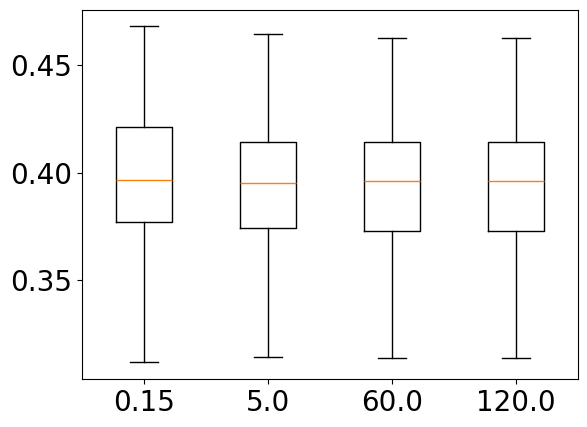

In [10]:
#Errorbar plot for sniplen 100 per c
snip_df = param_df[param_df['sniplen'] == 100]
data = [snip_df[snip_df['c'] == c]['f1'].to_numpy() for c in cs]
plt.boxplot(data)
plt.xticks([1,2,3,4], labels=cs)
plt.tick_params(axis='both', labelsize=20)

In [11]:
#Lineplot showing how c affects the accuracy of different sniplens

def getLineplot():
    for sniplen in SNIPPET_LENS:
        snip_df = param_df[param_df['sniplen'] == sniplen]
        ax = sns.lineplot(data=snip_df, x='c', y='f1', estimator='mean', errorbar=('ci', 99), n_boot=1000)
        ax.set_ylim(0, 0.6)
        ax.text(90, ax.lines[-1].get_ydata()[-2]-0.005, sniplen, bbox=dict(facecolor='gray', alpha=1))
    lbls = []
    for l in SNIPPET_LENS:
        lbls.append(str(l))
        lbls.append(str(l)+"_99%_ci")
    

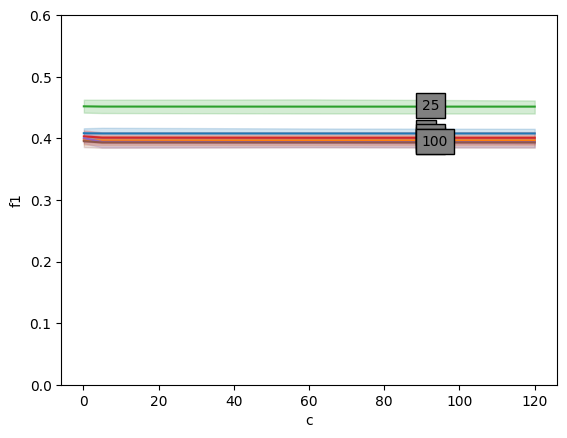

In [12]:
getLineplot()

## Plot accuracy and keylist_id (with different c's)

In [13]:
def getLineplotKeylists(c_val):
    start = 0
    increment = 0.05
    for sniplen in SNIPPET_LENS:
        snip_df = param_df[(param_df['sniplen'] == sniplen) & (param_df['c'] == c_val)]
        ax = sns.lineplot(data=snip_df, x='keylist_id', y='f1', estimator='mean', errorbar=('ci', 99), n_boot=1000)
        ax.set_ylim(0, 0.6)
        if sniplen == 5:
            start = ax.lines[-1].get_ydata()[-1]-increment
        ax.text(107, start+increment, sniplen, bbox=dict(facecolor=ax.lines[-1].get_color(), alpha=0.7))
        start += increment
    lbls = []
    for l in SNIPPET_LENS:
        lbls.append(str(l))
        lbls.append(str(l)+"_99%_ci")

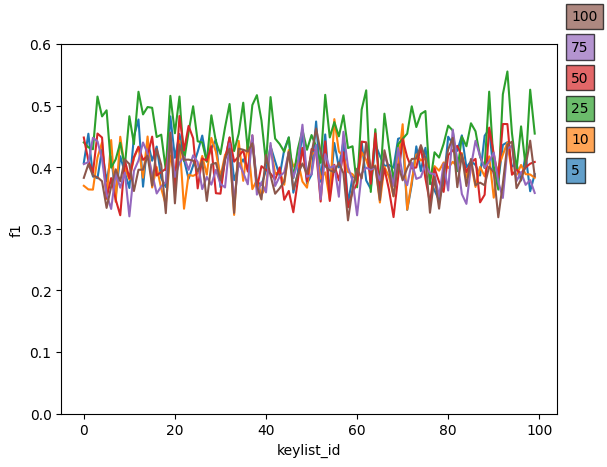

In [14]:
getLineplotKeylists(120)

In [15]:
keylist_diffs = []
maxss = []
minss = []
for i in SNIPPET_LENS:
    filtered = param_df[(param_df['sniplen'] == i)].sort_values('f1', ascending=False).drop_duplicates('keylist_id')[['f1']]
    mins = np.min(filtered.to_numpy())
    maxs = np.max(filtered.to_numpy())
    maxss.append(maxs)
    minss.append(mins)
    keylist_diffs.append(np.add(maxs, -mins))
print(keylist_diffs)
print(maxss)
print(minss)

[0.1519442779898043, 0.15542384148482957, 0.195422549374351, 0.16226199601004626, 0.14672660324030334, 0.15379324711893072]
[0.48275718775336224, 0.4780082557038674, 0.5553387609737995, 0.48357312849380546, 0.4726800546018162, 0.46802366372409837]
[0.3308129097635579, 0.32258441421903783, 0.35991621159944853, 0.3213111324837592, 0.3259534513615129, 0.31423041660516765]


In [16]:
min_max_diff = []
for i in range(100):
    filtered = param_df[(param_df['keylist_id'] == i)][['sniplen','f1']]
    maxs = np.array([np.max(filtered[filtered['sniplen'] == x]['f1'].to_numpy()) for x in SNIPPET_LENS])
    mins = np.array([np.min(filtered[filtered['sniplen'] == x]['f1'].to_numpy()) for x in SNIPPET_LENS])
    print(np.add(maxs, -mins))

[0.00068237 0.00301838 0.00097771 0.00598248 0.00111414 0.01446526]
[0.00041446 0.00222661 0.00313277 0.00345399 0.00347701 0.00328288]
[0.00041212 0.00122511 0.0034178  0.01058754 0.00691758 0.00251266]
[0.00082715 0.000326   0.0069263  0.00059739 0.00491674 0.00434864]
[0.00123132 0.00019747 0.00174925 0.00221546 0.00575417 0.00401708]
[0.00103879 0.00137842 0.00093101 0.00513717 0.00403905 0.00284811]
[0.00076657 0.00036844 0.00191596 0.00054633 0.01336374 0.00523232]
[0.00023457 0.00040901 0.00084991 0.00037701 0.00753463 0.00214916]
[0.00050844 0.00315844 0.00123279 0.00821831 0.00898456 0.01092174]
[0.00101439 0.00142876 0.00033287 0.00683311 0.01608257 0.00345923]
[0.00061882 0.00056663 0.00033104 0.01764521 0.01393517 0.00712036]
[0.00100223 0.00182852 0.00192112 0.000704   0.00901706 0.00335768]
[0.00089615 0.00248226 0.0020757  0.00074992 0.00836104 0.00145529]
[0.00056597 0.0007108  0.0032836  0.00643531 0.01228094 0.01745279]
[0.00123378 0.00279895 0.00266697 0.00672537 0.0

In [17]:
query = param_df.sort_values('f1', ascending=False).drop_duplicates(['keylist_id','sniplen'])[['sniplen','c']].to_numpy()
tuples = [(x[0], x[1]) for x in query]
print(Counter(tuples))

Counter({(75.0, 0.15): 85, (5.0, 0.15): 71, (10.0, 0.15): 69, (50.0, 0.15): 64, (100.0, 0.15): 61, (25.0, 0.15): 52, (25.0, 5.0): 20, (25.0, 120.0): 15, (50.0, 5.0): 15, (100.0, 5.0): 15, (100.0, 120.0): 14, (25.0, 60.0): 13, (10.0, 5.0): 13, (50.0, 120.0): 12, (10.0, 120.0): 11, (5.0, 60.0): 11, (100.0, 60.0): 10, (5.0, 5.0): 9, (50.0, 60.0): 9, (5.0, 120.0): 9, (10.0, 60.0): 7, (75.0, 5.0): 7, (75.0, 60.0): 4, (75.0, 120.0): 4})


In [18]:
print(param_df.sort_values('f1', ascending=False).drop_duplicates(['keylist_id','sniplen']))

      keylist_id  sniplen       c        f1
2242          93       25   60.00  0.555339
1496          62       25    0.15  0.528300
2361          98       25    5.00  0.525967
296           12       25    0.15  0.524518
2147          89       25  120.00  0.522600
...          ...      ...     ...       ...
1456          60       75    0.15  0.325953
797           33       10    5.00  0.322584
1644          68       50    0.15  0.321311
2204          91      100    0.15  0.320731
1413          58      100    5.00  0.314230

[600 rows x 4 columns]


In [19]:
print(param_df[param_df.sniplen == 10].sort_values('f1', ascending=False).drop_duplicates(['keylist_id'])[:100])

      keylist_id  sniplen       c        f1
1327          55       10  120.00  0.478008
1684          70       10    0.15  0.471291
340           14       10    0.15  0.452611
198            8       10   60.00  0.449408
677           28       10    5.00  0.447715
...          ...      ...     ...       ...
1565          65       10    5.00  0.342736
439           18       10  120.00  0.339197
532           22       10    0.15  0.334800
1708          71       10    0.15  0.332895
797           33       10    5.00  0.322584

[100 rows x 4 columns]


In [20]:
print(param_df[param_df.sniplen == '25'].sort_values('f1', ascending=False).drop_duplicates(['keylist_id'])[:100])

Empty DataFrame
Columns: [keylist_id, sniplen, c, f1]
Index: []


In [21]:
print(param_df[param_df.sniplen == '50'].sort_values('f1', ascending=False).drop_duplicates(['keylist_id'])[:100])

Empty DataFrame
Columns: [keylist_id, sniplen, c, f1]
Index: []


In [22]:
print(param_df[param_df.sniplen == '75'].sort_values('f1', ascending=False).drop_duplicates(['keylist_id'])[:100])

Empty DataFrame
Columns: [keylist_id, sniplen, c, f1]
Index: []


In [23]:
print(param_df[param_df.sniplen == 100].sort_values('f1', ascending=False).drop_duplicates(['keylist_id'])[:100]['c'].to_numpy())

[  0.15   5.   120.     0.15   0.15   0.15   0.15  60.   120.     0.15
   0.15   0.15   5.     0.15   0.15   5.     0.15   0.15  60.     5.
   0.15   0.15 120.     0.15   0.15   0.15   0.15   0.15   0.15   0.15
   0.15   0.15  60.     0.15  60.   120.     0.15   5.     0.15 120.
   0.15   0.15  60.     0.15   5.   120.     0.15   0.15   5.     5.
   0.15   0.15 120.     0.15   0.15   0.15 120.   120.     0.15 120.
   5.   120.     0.15 120.     0.15   0.15   0.15   0.15   0.15   0.15
   0.15  60.     0.15   0.15   5.     0.15   0.15   0.15 120.     0.15
   5.   120.    60.     5.   120.    60.     5.     0.15   0.15   0.15
   0.15   0.15   0.15   0.15 120.     0.15   5.     0.15   0.15   5.  ]


In [24]:
print(df[(df.sniplen == 100) & (df.c==120)].sort_values('f1', ascending=False))

      keylist_id  sniplen      c     tol        f1  \
1247          51      100  120.0  0.0001  0.462853   
479           19      100  120.0  0.0001  0.455704   
1967          81      100  120.0  0.0001  0.447608   
2375          98      100  120.0  0.0001  0.443015   
2279          94      100  120.0  0.0001  0.441334   
...          ...      ...    ...     ...       ...   
1847          76      100  120.0  0.0001  0.326049   
815           33      100  120.0  0.0001  0.325831   
455           18      100  120.0  0.0001  0.325341   
2207          91      100  120.0  0.0001  0.318695   
1415          58      100  120.0  0.0001  0.313642   

                                    important_feats_7-8  \
1247  [226, 291, 152, 143, 118, 179, 142, 220, 136, ...   
479   [226, 291, 280, 118, 152, 123, 195, 179, 60, 3...   
1967  [152, 291, 226, 136, 315, 312, 118, 213, 146, ...   
2375  [275, 226, 179, 152, 291, 314, 146, 128, 136, ...   
2279  [179, 226, 143, 60, 295, 280, 314, 264, 152, 2... 

In [25]:
print(Counter([x for y in df.sort_values('f1', ascending=False)[:1]['important_feats_9-12'].to_numpy() for x in y]))

Counter({243: 1, 163: 1, 325: 1, 195: 1, 296: 1, 184: 1, 43: 1, 326: 1, 227: 1, 329: 1, 169: 1, 150: 1, 124: 1, 181: 1, 315: 1, 44: 1, 145: 1, 122: 1, 239: 1, 126: 1, 281: 1, 311: 1, 211: 1, 298: 1, 58: 1, 160: 1, 153: 1, 206: 1, 157: 1, 262: 1, 128: 1, 142: 1, 284: 1, 201: 1, 251: 1, 259: 1, 45: 1, 277: 1, 294: 1, 139: 1, 327: 1, 147: 1, 173: 1, 175: 1, 6: 1, 171: 1, 234: 1, 337: 1, 207: 1, 253: 1, 121: 1, 237: 1, 218: 1, 197: 1, 118: 1, 188: 1, 99: 1, 88: 1, 200: 1, 166: 1, 48: 1, 208: 1, 47: 1, 131: 1, 167: 1, 161: 1, 194: 1, 176: 1, 130: 1, 15: 1, 46: 1, 303: 1, 137: 1, 199: 1, 133: 1, 185: 1, 94: 1, 275: 1, 14: 1, 267: 1, 317: 1, 334: 1, 320: 1, 183: 1, 101: 1, 135: 1, 151: 1, 89: 1, 93: 1, 52: 1, 162: 1, 269: 1, 95: 1, 84: 1, 13: 1, 256: 1, 136: 1, 146: 1, 279: 1, 236: 1})


## Insight into important featues if used HPFV

In [26]:
test_conllu_line = "1\tAikojen\taika\tNOUN\tN\tCase=Gen|Number=Plur\t2\tnsubj\t_\t_\n2\tkuluessa\tkulua\tVERB\tV\tCase=Ine|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t7\tadvcl\t_\t_\n3\tmuinaisina\tmuinainen\tADJ\tA\tCase=Ess|Degree=Pos|Derivation=Inen|Number=Plur\t4\tamod\t_\t_\n4\taikoina\taika\tNOUN\tN\tCase=Ess|Number=Plur\t5\tobl\t_\t_\n5\tsyntynyt\tsynty\u00e4\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t6\tacl\t_\t_\n6\tpahuus\tpahuus\tNOUN\tN\tCase=Nom|Derivation=Vs|Number=Sing\t7\tnsubj\t_\t_\n7\tkasvaa\tkasvaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t12\tpunct\t_\t_\n9\ti\u00e4inen\ti\u00e4inen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t10\tamod\t_\t_\n10\tpimeys\tpimeys\tNOUN\tN\tCase=Nom|Derivation=Vs|Number=Sing\t12\tnsubj:cop\t_\t_\n11\ton\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t12\tcop\t_\t_\n12\tvalloillaan\tvalloillaan\tADV\tAdv\t_\t7\tconj\t_\t_\n13\tja\tja\tCCONJ\tC\t_\t14\tcc\t_\t_\n14\tyritt\u00e4\u00e4\tyritt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t7\tconj\t_\t_\n15\tsy\u00f6st\u00e4\tsy\u00f6st\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t14\txcomp\t_\t_\n16\tkoko\tkoko\tADJ\tA\t_\t17\tamod\t_\t_\n17\tmaan\tmaa\tNOUN\tN\tCase=Gen|Number=Sing\t15\tobj\t_\t_\n18\tp\u00e4\u00e4ttym\u00e4tt\u00f6m\u00e4\u00e4n\tp\u00e4\u00e4ttym\u00e4t\u00f6n\tADJ\tA\tCase=Ill|Degree=Pos|Derivation=Ton|Number=Sing\t19\tamod\t_\t_\n19\ty\u00f6h\u00f6n\ty\u00f6\tNOUN\tN\tCase=Ill|Number=Sing\t15\tobl\t_\t_\n20\t.\t.\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n1\tT\u00e4t\u00e4\tt\u00e4m\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Dem\t2\tdet\t_\t_\n2\tpahuutta\tpahuutta\tNOUN\tN\tCase=Par|Derivation=Vs|Number=Sing\t5\tobj\t_\t_\n3\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t5\taux\t_\t_\n4\tvoi\tvoida\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t5\taux\t_\t_\n5\tly\u00f6d\u00e4\tly\u00f6d\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n6\tkukaan\tkukaan\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t5\tnsubj\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n8\tpaitsi\tpaitsi\tADP\tAdp\t_\t18\tcase\t_\t_\n9\tyksi\tyksi\tNUM\tNum\tCase=Nom|Number=Sing|NumType=Card\t18\tnummod\t_\t_\n10\tja\tja\tCCONJ\tC\t_\t11\tcc\t_\t_\n11\tainoa\tainoa\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t9\tconj\t_\t_\n12\tValveuden\tvalveus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t13\tnsubj\t_\t_\n13\tvalitsema\tvalita\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Agt|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n14\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n15\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t17\tnsubj\t_\t_\n16\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t15\tflat:name\t_\t_\n17\ttuleva\ttulla\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n18\tsankari\tsankari\tNOUN\tN\tCase=Nom|Number=Sing\t6\tappos\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tVirheet\u00f6n\tvirheet\u00f6n\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Ton|Number=Sing\t2\tamod\t_\t_\n2\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n4\tjoka\tjoka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rel\t5\tnsubj\t_\t_\n5\tkantaa\tkantaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tacl:relcl\t_\t_\n6\tvalon\tvalo\tNOUN\tN\tCase=Gen|Number=Sing\t7\tnmod:poss\t_\t_\n7\tamulettia\tamuletti\tNOUN\tN\tCase=Par|Number=Sing\t5\tobj\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t10\tcc\t_\t_\n9\tt\u00e4ydellisesti\tt\u00e4ydellisesti\tADV\tAdv\tDerivation=Sti\t10\tadvmod\t_\t_\n10\tt\u00e4ytt\u00e4\u00e4\tt\u00e4ytt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t5\tconj\t_\t_\n11\tValveuden\tvalveus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t12\tnmod:poss\t_\t_\n12\ttahdon\ttahto\tNOUN\tN\tCase=Gen|Number=Sing\t10\tobj\t_\t_\n13\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tKun\tkun\tSCONJ\tC\t_\t4\tmark\t_\t_\n2\taika\taika\tNOUN\tN\tCase=Nom|Number=Sing\t4\tnsubj:cop\t_\t_\n3\ton\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\t_\n4\tt\u00e4ysi\tt\u00e4ysi\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t7\tadvcl\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n6\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t7\tnsubj\t_\t_\n7\tuhraa\tuhrata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n8\titsens\u00e4\titse\tPRON\tPron\tCase=Gen|Number=Sing|Person[psor]=3|Reflex=Yes\t7\tobj\t_\t_\n9\tkaikkien\tkaikki\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Ind\t7\tobl\t_\t_\n10\tpuolesta\tpuolesta\tADP\tAdp\tAdpType=Post\t9\tcase\t_\t_\n11\ttaistelussa\ttaistelu\tNOUN\tN\tCase=Ine|Derivation=U|Number=Sing\t7\tobl\t_\t_\n12\tpimeytt\u00e4\tpimeys\tNOUN\tN\tCase=Par|Derivation=Vs|Number=Sing\t11\tnmod\t_\t_\n13\tvastaan\tvastaan\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n15\tmutta\tmutta\tCCONJ\tC\t_\t18\tcc\t_\t_\n16\tkuolemakaan\tkuolema\tNOUN\tN\tCase=Nom|Clitic=Kaan|Number=Sing\t18\tnsubj\t_\t_\n17\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t18\taux\t_\t_\n18\tsaa\tsaada\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t7\tconj\t_\t_\n19\th\u00e4nest\u00e4\th\u00e4n\tPRON\tPron\tCase=Ela|Number=Sing|Person=3|PronType=Prs\t18\tobl\t_\t_\n20\tvoittoa\tvoitto\tNOUN\tN\tCase=Par|Number=Sing\t18\tobj\t_\t_\n21\t.\t.\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n1\tValittu\tvalita\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Pass\t2\tnsubj\t_\t_\n2\tvoittaa\tvoittaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tlopullisesti\tlopullisesti\tADV\tAdv\tDerivation=Sti\t2\tadvmod\t_\t_\n4\t\t\tPROPN\tN\tCase=Gen|Number=Sing\t2\tobj\t_\t_\n5\tjoukkoineen\tjoukko\tNOUN\tN\tCase=Com|Person[psor]=3\t4\tnmod\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n8\tmaailmaan\tmaailma\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n9\tpalaa\tpalata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\thyvyys\thyvyys\tNOUN\tN\tCase=Nom|Number=Sing\t9\tnsubj\t_\t_\n11\tja\tja\tCCONJ\tC\t_\t12\tcc\t_\t_\n12\trauha\trauha\tNOUN\tN\tCase=Nom|Number=Sing\t10\tconj\t_\t_\n13\tkuin\tkuin\tSCONJ\tC\t_\t15\tmark\t_\t_\n14\tentisin\u00e4\tentinen\tADJ\tA\tCase=Ess|Degree=Pos|Derivation=Inen|Number=Plur\t15\tamod\t_\t_\n15\taikoina\taika\tNOUN\tN\tCase=Ess|Number=Plur\t9\tadvcl\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tJa\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n2\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t9\tnsubj\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n4\tjotka\tjoka\tPRON\tPron\tCase=Nom|Number=Plur|PronType=Rel\t7\tnsubj\t_\t_\n5\tovat\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t7\taux\t_\t_\n6\tvalittua\tvalittu\tNOUN\tN\tCase=Par|Number=Sing\t7\tobj\t_\t_\n7\tseuranneet\tseurata\tVERB\tV\tCase=Nom|Degree=Pos|Number=Plur|PartForm=Past|VerbForm=Part|Voice=Act\t2\tacl:relcl\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n9\tp\u00e4\u00e4sev\u00e4t\tp\u00e4\u00e4st\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n10\th\u00e4nen\th\u00e4n\tPRON\tPron\tCase=Gen|Number=Sing|Person=3|PronType=Prs\t9\tobl\t_\t_\n11\tkanssaan\tkanssa\tADP\tAdp\tAdpType=Post|Person[psor]=3\t10\tcase\t_\t_\n12\tValveuden\tvalveus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t9\tobl\t_\t_\n13\tluo\tluo\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\tikuiseen\tikuinen\tADJ\tA\tCase=Ill|Degree=Pos|Derivation=Inen|Number=Sing\t15\tamod\t_\t_\n15\tiloon\tilo\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tJoten\tjoten\tADV\tAdv\t_\t3\tadvmod\t_\t_\n3\tryhdy\tryhty\u00e4\tVERB\tV\tMood=Imp|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tsin\u00e4kin\tsin\u00e4\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|Person=2|PronType=Prs\t3\tnsubj\t_\t_\n5\tvalittu-ehdokkaaksi\tvalittu#ehdokas\tNOUN\tN\tCase=Tra|Number=Sing\t3\txcomp:ds\t_\t_\n6\t!\t!\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tJos\tjos\tSCONJ\tC\t_\t3\tmark\t_\t_\n2\tet\tei\tAUX\tV\tNumber=Sing|Person=2|Polarity=Neg|VerbForm=Fin|Voice=Act\t3\taux\t_\t_\n3\tkuole\tkuolla\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t9\tadvcl\t_\t_\n4\theti\theti\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tensimm\u00e4isess\u00e4\tensimm\u00e4inen\tADJ\tNum\tCase=Ine|Derivation=Inen|Number=Sing|NumType=Ord\t6\tamod\t_\t_\n6\ttaistelussa\ttaistelu\tNOUN\tN\tCase=Ine|Derivation=U|Number=Sing\t3\tobl\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n8\tsaatat\tsaattaa\tAUX\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t9\taux\t_\t_\n9\tvoittaa\tvoittaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n10\tikuisen\tikuinen\tADJ\tA\tCase=Gen|Degree=Pos|Derivation=Inen|Number=Sing\t11\tamod\t_\t_\n11\tel\u00e4m\u00e4n\tel\u00e4m\u00e4\tNOUN\tN\tCase=Gen|Number=Sing\t9\tobj\t_\t_\n12\t!\t!\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n13\t\"\t\"\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n2\tEnt\u00e4\tent\u00e4\tADV\tAdv\t_\t5\tadvmod\t_\t_\n3\tjos\tjos\tSCONJ\tC\t_\t5\tmark\t_\t_\n4\ten\tei\tAUX\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t5\taux\t_\t_\n5\thalua\thaluta\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t0\troot\t_\t_\n6\t?\t?\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n8\tmin\u00e4\tmin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=1|PronType=Prs\t9\tnsubj\t_\t_\n9\tkysyin\tkysy\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin|Voice=Act\t5\tparataxis\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\t\u00c4l\u00e4\tei\tAUX\tV\tMood=Imp|Number=Sing|Person=2|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n3\tole\tolla\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t4\tcop\t_\t_\n4\tpelkuri\tpelkuri\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n5\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n6\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n7\tjyr\u00e4htiv\u00e4t\tjyr\u00e4ht\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t4\tparataxis\t_\t_\n8\thyvikset\thyvi\tADJ\tA\tCase=Nom|Number=Plur\t7\tnsubj\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tOnko\tolla\tAUX\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\t_\n3\tmeiss\u00e4\tmin\u00e4\tPRON\tPron\tCase=Ine|Number=Plur|PronType=Dem\t4\tobl\t_\t_\n4\tkeness\u00e4k\u00e4\u00e4n\tkukaan\tPRON\tPron\tCase=Ine|Number=Sing|PronType=Ind\t0\troot\t_\t_\n5\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t4\tnsubj:cop\t_\t_\n6\tpelastamisen\tpelastaminen\tNOUN\tN\tCase=Gen|Derivation=Minen|Number=Sing\t7\tnmod:poss\t_\t_\n7\tarvoista\tarvoinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Sing\t5\tnmod\t_\t_\n8\t?\t?\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tSiet\u00e4isimme\tsiet\u00e4\u00e4\tVERB\tV\tMood=Cnd|Number=Plur|Person=1|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t1\tobj\t_\t_\n3\tkuolla\tkuolla\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t1\txcomp\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tmutisi\tmutista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t1\tparataxis\t_\t_\n7\tViikatemies\tviikate#mies\tNOUN\tN\tCase=Nom|Number=Sing\t6\tnsubj\t_\t_\n8\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tParas\thyv\u00e4\tADJ\tA\tCase=Nom|Degree=Sup|Number=Sing\t0\troot\t_\t_\n3\titse\titse\tADV\tAdv\t_\t5\tadvmod\t_\t_\n4\titsens\u00e4\titse\tPRON\tPron\tCase=Gen|Number=Sing|Person[psor]=3|Reflex=Yes\t5\tobj\t_\t_\n5\tpelastaa\tpelastaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp:ds\t_\t_\n6\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n8\ttokaisi\ttokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n9\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t8\tnsubj\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tTe\tsin\u00e4\tPRON\tPron\tCase=Nom|Number=Plur|Person=2|PronType=Prs\t3\tnsubj:cop\t_\t_\n3\tharhaoppiset\tharhaoppinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Plur\t0\troot\t_\t_\n4\t!\t!\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tHirteen\thirre\tNOUN\tN\tCase=Ill|Number=Sing\t2\tobl\t_\t_\n2\tjoudatte\tjoudattaa\tVERB\tV\tMood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\t!\t!\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n5\tpauhasivat\tpauhata\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n6\thyvikset\thyvi\tADJ\tA\tCase=Nom|Number=Plur\t5\tnsubj\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMin\u00e4\tmin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=1|PronType=Prs\t3\tnsubj\t_\t_\n2\ten\tei\tAUX\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t3\taux\t_\t_\n3\tuskaltanut\tuskaltaa\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n4\tmainitakaan\tmainita\tVERB\tV\tClitic=Kaan|InfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t3\txcomp\t_\t_\n5\tmuista\tmuu\tPRON\tPron\tCase=Ela|Number=Plur|PronType=Ind\t6\tdet\t_\t_\n6\tmahdollisuuksista\tmahdollisuus\tNOUN\tN\tCase=Ela|Derivation=Llinen,Vs|Number=Plur\t4\tobl\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n8\tniin\tniin\tADV\tAdv\t_\t9\tadvmod\t_\t_\n9\tlopetin\tlopettaa\tVERB\tV\tMood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin|Voice=Act\t3\tconj\t_\t_\n10\tt\u00e4m\u00e4n\tt\u00e4m\u00e4\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t11\tdet\t_\t_\n11\tpaperin\tpaperi\tNOUN\tN\tCase=Gen|Number=Sing\t12\tnmod:gobj\t_\t_\n12\ttuhlaamisen\ttuhlaaminen\tNOUN\tN\tCase=Gen|Derivation=Minen|Number=Sing\t9\tobj\t_\t_\n13\t,\t,\tPUNCT\tPunct\t_\t16\tpunct\t_\t_\n14\tkoska\tkoska\tSCONJ\tC\t_\t16\tmark\t_\t_\n15\ttila\ttila\tNOUN\tN\tCase=Nom|Number=Sing\t16\tnsubj\t_\t_\n16\tloppuu\tloppua\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t9\tadvcl\t_\t_\n17\tja\tja\tCCONJ\tC\t_\t21\tcc\t_\t_\n18\tminun\tmin\u00e4\tPRON\tPron\tCase=Gen|Number=Sing|Person=1|PronType=Prs\t21\tnsubj\t_\t_\n19\tpit\u00e4isi\tpit\u00e4\u00e4\tAUX\tV\tMood=Cnd|Number=Sing|Person=3|VerbForm=Fin|Voice=Act\t21\taux\t_\t_\n20\tolla\tolla\tAUX\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t21\taux\t_\t_\n21\ttekem\u00e4ss\u00e4\ttehd\u00e4\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t16\tconj\t_\t_\n22\tjotain\tjokin\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t24\tdet\t_\t_\n23\toikeasti\toikeasti\tADV\tAdv\tDerivation=Sti\t24\tadvmod\t_\t_\n24\thy\u00f6dyllist\u00e4\thy\u00f6dyllinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Llinen|Number=Sing\t21\tobj\t_\t_\n25\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tsyv\u00e4\u00e4n\tsyv\u00e4\u00e4n\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n5\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tkyn\u00e4n\tkyn\u00e4\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobj\t_\t_\n7\tmustepulloon\tmuste#pullo\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tj\u00e4i\tj\u00e4\u00e4d\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tkatsomaan\tkatsoa\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t9\txcomp\t_\t_\n11\thorisonttiin\thorisontti\tNOUN\tN\tCase=Ill|Number=Sing\t10\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tPahuksen\tpahus\tNOUN\tN\tCase=Gen|Number=Sing\t3\tnmod:poss\t_\t_\n3\tprofetia\tprofetia\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n4\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n5\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tLinnan\tlinna\tNOUN\tN\tCase=Gen|Number=Sing\t2\tnmod:poss\t_\t_\n2\tkorkeimmasta\tkorkea\tADJ\tA\tCase=Ela|Degree=Sup|Number=Sing\t3\tamod\t_\t_\n3\ttornista\ttorni\tNOUN\tN\tCase=Ela|Number=Sing\t4\tobl\t_\t_\n4\tn\u00e4ki\tn\u00e4hd\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=0|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n5\tymp\u00e4r\u00f6iv\u00e4n\tymp\u00e4r\u00f6id\u00e4\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t6\tacl\t_\t_\n6\tkaupungin\tkaupunki\tNOUN\tN\tCase=Gen|Number=Sing\t11\tnmod\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t8\tcc\t_\t_\n8\tpeltomaiden\tpelto#maa\tNOUN\tN\tCase=Gen|Number=Plur\t6\tconj\t_\t_\n9\tyli\tyli\tADP\tAdp\tAdpType=Post\t6\tcase\t_\t_\n10\tautioon\tautio\tADJ\tA\tCase=Ill|Degree=Pos|Number=Sing\t11\tamod\t_\t_\n11\treunaseutuun\treuna#seutu\tNOUN\tN\tCase=Ill|Number=Sing\t4\tobl\t_\t_\n12\t,\t,\tPUNCT\tPunct\t_\t15\tpunct\t_\t_\n13\tjoka\tjoka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rel\t15\tnsubj\t_\t_\n14\tv\u00e4hitellen\tv\u00e4hitellen\tADV\tAdv\t_\t15\tadvmod\t_\t_\n15\tnousi\tnousta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t11\tacl:relcl\t_\t_\n16\tsynkkyytt\u00e4\tsynkkyys\tNOUN\tN\tCase=Par|Number=Sing\t17\tobj\t_\t_\n17\thuokuvaksi\thuokua\tVERB\tV\tCase=Tra|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n18\tvuoristoksi\tvuoristo\tNOUN\tN\tCase=Tra|Number=Sing\t15\txcomp\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tsiirtyi\tsiirty\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tvieress\u00e4\u00e4n\tvieress\u00e4\tADV\tAdv\tPerson[psor]=3\t4\tadvmod\t_\t_\n4\tolevan\tolla\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t6\tacl\t_\t_\n5\tjyhke\u00e4n\tjyhke\u00e4\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t6\tamod\t_\t_\n6\tkaukoputken\tkauko#putki\tNOUN\tN\tCase=Gen|Number=Sing\t2\tobl\t_\t_\n7\t\u00e4\u00e4relle\t\u00e4\u00e4ri\tADP\tAdp\tAdpType=Post\t6\tcase\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tsill\u00e4\tse\tPRON\tPron\tCase=Ade|Number=Sing|PronType=Dem\t9\tobl\t_\t_\n11\ttaas\ttaas\tADV\tAdv\t_\t9\tadvmod\t_\t_\n12\tvuorten\tvuori\tNOUN\tN\tCase=Gen|Number=Plur\t14\tobl\t_\t_\n13\tv\u00e4liin\tv\u00e4liin\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\tj\u00e4\u00e4v\u00e4\u00e4n\tj\u00e4\u00e4d\u00e4\tVERB\tV\tCase=Ill|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t15\tacl\t_\t_\n15\tsolaan\tsola\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n16\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n17\tmiss\u00e4\tmik\u00e4\tPRON\tPron\tCase=Ine|Number=Sing|PronType=Rel\t18\tobl\t_\t_\n18\tkulki\tkulkea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t15\tacl:relcl\t_\t_\n19\tvaltakunnat\tvalta#kunta\tNOUN\tN\tCase=Nom|Number=Plur\t20\tobj\t_\t_\n20\tyhdist\u00e4v\u00e4\tyhdist\u00e4\u00e4\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t21\tacl\t_\t_\n21\tvaltatie\tvalta#tie\tNOUN\tN\tCase=Nom|Number=Sing\t18\tnsubj\t_\t_\n22\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tTaistelu\ttaistelu\tNOUN\tN\tCase=Nom|Derivation=U|Number=Sing\t6\tnsubj:cop\t_\t_\n2\tsiell\u00e4\tsiell\u00e4\tADV\tAdv\t_\t1\tadvmod\t_\t_\n3\toli\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t6\tcop\t_\t_\n4\tedelleen\tedelleen\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tt\u00e4ydess\u00e4\tt\u00e4ysi\tADJ\tA\tCase=Ine|Degree=Pos|Number=Sing\t6\tamod\t_\t_\n6\tvauhdissa\tvauhti\tNOUN\tN\tCase=Ine|Number=Sing\t0\troot\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n2\tOn\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t6\tcop\t_\t_\n3\ttuokin\ttuokin\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|PronType=Dem\t6\tnsubj:cop\t_\t_\n4\ttaas\ttaas\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tj\u00e4rkev\u00e4\tj\u00e4rkev\u00e4\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t6\tamod\t_\t_\n6\ttapa\ttapa\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n7\tkuluttaa\tkuluttaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t6\tacl\t_\t_\n8\taikaa\taika\tNOUN\tN\tCase=Par|Number=Sing\t7\tobj\t_\t_\n9\tja\tja\tCCONJ\tC\t_\t10\tcc\t_\t_\n10\tresursseja\tresurssi\tNOUN\tN\tCase=Par|Number=Plur\t8\tconj\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n1\tLuulisi\tluulla\tVERB\tV\tMood=Cnd|Number=Sing|Person=0|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n3\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t8\tmark\t_\t_\n4\tnelj\u00e4ss\u00e4\tnelj\u00e4\tNUM\tNum\tCase=Ine|Number=Sing|NumType=Card\t5\tcompound\t_\t_\n5\tsadassa\tsata\tNUM\tNum\tCase=Ine|Number=Sing|NumType=Card\t6\tnummod\t_\t_\n6\tvuodessa\tvuosi\tNOUN\tN\tCase=Ine|Number=Sing\t8\tobl\t_\t_\n7\tihminen\tihminen\tNOUN\tN\tCase=Nom|Number=Sing\t8\tnsubj\t_\t_\n8\tkeksisi\tkeksi\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=3|VerbForm=Fin|Voice=Act\t1\tccomp\t_\t_\n9\tj\u00e4rkev\u00e4\u00e4kin\tj\u00e4rkev\u00e4\tADJ\tA\tCase=Nom|Clitic=Kin|Degree=Pos|Number=Sing\t10\tamod\t_\t_\n10\ttekemist\u00e4\ttekeminen\tNOUN\tN\tCase=Par|Derivation=Minen|Number=Sing\t8\tobj\t_\t_\n11\t,\t,\tPUNCT\tPunct\t_\t17\tpunct\t_\t_\n12\tmutta\tmutta\tCCONJ\tC\t_\t17\tcc\t_\t_\n13\tei\tei\tVERB\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t17\taux\t_\t_\n14\tn\u00e4ht\u00e4v\u00e4sti\tn\u00e4hd\u00e4\tVERB\tV\tDerivation=Sti\t17\tadvmod\t_\t_\n15\t,\t,\tPUNCT\tPunct\t_\t14\tpunct\t_\t_\n16\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t17\tnsubj\t_\t_\n17\tk\u00e4\u00e4nsi\tk\u00e4\u00e4nt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t1\tconj\t_\t_\n18\tkaukoputkea\tkauko#putki\tNOUN\tN\tCase=Par|Number=Sing\t17\tobj\t_\t_\n19\thitusen\thitusen\tADV\tAdv\t_\t17\tadvmod\t_\t_\n20\t,\t,\tPUNCT\tPunct\t_\t23\tpunct\t_\t_\n21\tjotta\tjotta\tSCONJ\tC\t_\t23\tmark\t_\t_\n22\tn\u00e4kyviin\tn\u00e4ky\u00e4\tVERB\tV\tCase=Ill|Degree=Pos|Number=Plur|PartForm=Pres|VerbForm=Part|Voice=Act\t23\txcomp\t_\t_\n23\ttuli\ttulla\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t17\tadvcl\t_\t_\n24\tvuorenrinteell\u00e4\tvuoren#rinne\tNOUN\tN\tCase=Ade|Number=Sing\t25\tobl\t_\t_\n25\tseisoskeleva\tseisoskella\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t26\tacl\t_\t_\n26\thahmo\thahmo\tNOUN\tN\tCase=Nom|Number=Sing\t23\tnsubj\t_\t_\n27\tmustassa\tmusta\tADJ\tA\tCase=Ine|Degree=Pos|Number=Sing\t28\tamod\t_\t_\n28\thaarniskassa\thaarniska\tNOUN\tN\tCase=Ine|Number=Sing\t26\tnmod\t_\t_\n29\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tPatsastelet\tpatsastella\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tsiell\u00e4\tsiell\u00e4\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\tlatelet\tladella\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tmahtipontisia\tmahtipontinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Plur\t7\tamod\t_\t_\n7\tsolvauksia\tsolvaus\tNOUN\tN\tCase=Par|Number=Plur\t5\tobj\t_\t_\n8\tep\u00e4k\u00e4yt\u00e4nn\u00f6llisten\tep\u00e4#k\u00e4yt\u00e4nn\u00f6llinen\tADJ\tA\tCase=Gen|Degree=Pos|Derivation=Llinen|Number=Plur\t9\tamod\t_\t_\n9\tpiikkikoristeidesi\tpiikki#koriste\tNOUN\tN\tCase=Gen|Number=Plur|Number[psor]=Sing|Person[psor]=1\t5\tobl\t_\t_\n10\tkanssa\tkanssa\tADP\tAdp\tAdpType=Post\t9\tcase\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMuuttuisit\tmuuttua\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tjo\tjo\tADV\tAdv\t_\t1\tadvmod\t_\t_\n3\tlohik\u00e4\u00e4rmeeksi\tlohi#k\u00e4\u00e4rme\tNOUN\tN\tCase=Tra|Number=Sing\t1\txcomp\t_\t_\n4\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\ttyhjent\u00e4isit\ttyhjent\u00e4\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t1\tconj\t_\t_\n6\tkoko\tkoko\tADJ\tA\t_\t7\tamod\t_\t_\n7\ttantereen\ttantere\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobj\t_\t_\n8\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\tTai\ttai\tCCONJ\tC\t_\t2\tcc\t_\t_\n2\taivopesisit\taivopesita\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tvastustajat\tvastustaja\tNOUN\tN\tCase=Nom|Derivation=Ja|Number=Plur\t2\tobj\t_\t_\n4\ttai\ttai\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\ttekisit\ttehd\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tjotain\tjokin\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t5\tobj\t_\t_\n7\tkaikilla\tkaikki\tPRON\tPron\tCase=Ade|Number=Plur|PronType=Ind\t8\tdet\t_\t_\n8\tylivoimillasi\tyli#voima\tADJ\tA\tCase=Ade|Number=Plur|Number[psor]=Sing|Person[psor]=2\t5\tobl\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMutta\tmutta\tCCONJ\tC\t_\t2\tcc\t_\t_\n2\tleikki\u00e4h\u00e4n\tleikki\tNOUN\tN\tCase=Nom|Clitic=Han|Number=Sing\t0\troot\t_\t_\n3\tt\u00e4m\u00e4\tt\u00e4m\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Dem\t2\tnsubj:cop\t_\t_\n4\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t2\tdet\t_\t_\n5\tsinulle\tsin\u00e4\tPRON\tPron\tCase=All|Number=Sing|Person=2|PronType=Prs\t2\tobl\t_\t_\n6\tvain\tvain\tADV\tAdv\t_\t5\tadvmod\t_\t_\n7\ton\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tcop\t_\t_\n8\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tToisten\ttoinen\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Rcp\t2\tnmod:gsubj\t_\t_\n2\tkustannuksella\tkustannus\tNOUN\tN\tCase=Ade|Number=Sing\t0\troot\t_\t_\n3\t...\t...\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tk\u00e4\u00e4nsi\tk\u00e4\u00e4nt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\ttaas\ttaas\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\tkaukoputkea\tkauko#putki\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n5\tja\tja\tCCONJ\tC\t_\t6\tcc\t_\t_\n6\tbongasi\tbongata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n7\tteinipojan\tteini#poika\tNOUN\tN\tCase=Gen|Number=Sing\t8\tnsubj\t_\t_\n8\tniitt\u00e4m\u00e4ss\u00e4\tniitt\u00e4\u00e4\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t6\txcomp:ds\t_\t_\n9\tluurankosotilaita\tluuran#koso#tilaita\tNOUN\tN\tCase=Par|Number=Plur\t8\tobj\t_\t_\n10\tleimuavalla\tleimuta\tVERB\tV\tCase=All|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t11\tacl\t_\t_\n11\tmiekalla\tmiekka\tNOUN\tN\tCase=Ade|Number=Sing\t8\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t0\tpunct\t_\t_\n1\tJa\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n2\tsin\u00e4\tsin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=2|PronType=Prs\t5\tnsubj\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n4\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t5\tnsubj\t_\t_\n5\tosoitteli\tosoitella\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\tsyytt\u00e4v\u00e4sti\tsyytt\u00e4v\u00e4sti\tADV\tAdv\tDerivation=Sti\t5\tadvmod\t_\t_\n7\tilmaa\tilma\tNOUN\tN\tCase=Par|Number=Sing\t5\tobj\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n9\t\"\t\"\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n10\ttyhj\u00e4np\u00e4iv\u00e4inen\ttyhj\u00e4n#p\u00e4iv\u00e4inen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t11\tamod\t_\t_\n11\tkynttil\u00e4nvalaja\tkynttil\u00e4n#valaja\tNOUN\tN\tCase=Nom|Number=Sing\t2\tappos\t_\t_\n12\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n13\tluulet\tluulla\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n14\tolevasi\tolla\tAUX\tV\tCase=Gen|Degree=Pos|Number=Sing|Number[psor]=Sing|PartForm=Pres|Person[psor]=2|VerbForm=Part|Voice=Act\t16\tcop\t_\t_\n15\toikeasti\toikeasti\tADV\tAdv\tDerivation=Sti\t16\tadvmod\t_\t_\n16\tmerkityksellinen\tmerkityksellinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Llinen|Number=Sing\t13\txcomp\t_\t_\n17\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tMik\u00e4\tmik\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Int\t3\tnsubj\t_\t_\n2\tmuka\tmuka\tADV\tAdv\t_\t3\tadvmod\t_\t_\n3\ttekee\ttehd\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tsinusta\tsin\u00e4\tPRON\tPron\tCase=Ela|Number=Sing|Person=2|PronType=Prs\t3\tobl\t_\t_\n5\tenemm\u00e4n\tenemm\u00e4n\tADV\tAdv\t_\t6\tadvmod\t_\t_\n6\tvalitun\tvalita\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Pass\t3\tobj\t_\t_\n7\tkuin\tkuin\tSCONJ\tC\t_\t9\tmark\t_\t_\n8\tjoku\tjoku\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t9\tdet\t_\t_\n9\ttoinen\ttoinen\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rcp\t5\tadvcl\t_\t_\n10\t,\t,\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n11\th\u00e4h\th\u00e4h\tINTJ\tInterj\t_\t3\tdiscourse\t_\t_\n12\t?\t?\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tJoku\tjoku\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t3\tnsubj\t_\t_\n2\tvain\tvain\tADV\tAdv\t_\t3\tadvmod\t_\t_\n3\tp\u00e4\u00e4tti\tp\u00e4\u00e4tt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n5\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t9\tmark\t_\t_\n6\tsin\u00e4\tsin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=2|PronType=Prs\t9\tnsubj:cop\t_\t_\n7\tnyt\tnyt\tADV\tAdv\t_\t9\tadvmod\t_\t_\n8\tolet\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t9\tcop\t_\t_\n9\tt\u00e4rkein\tt\u00e4rke\u00e4\tADJ\tA\tCase=Nom|Degree=Sup|Number=Sing\t3\tccomp\t_\t_\n10\tkaikista\tkaikki\tPRON\tPron\tCase=Ela|Number=Plur|PronType=Ind\t9\tnmod\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tOlet\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t5\tcop\t_\t_\n2\tihan\tihan\tADV\tAdv\t_\t5\tadvmod\t_\t_\n3\tyht\u00e4\tyht\u00e4\tADV\tAdv\t_\t5\tadvmod\t_\t_\n4\tlailla\tlailla\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\tmurhaaja\tmurhaaja\tNOUN\tN\tCase=Nom|Derivation=Ja|Number=Sing\t0\troot\t_\t_\n6\tja\tja\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\ttuhoaja\ttuhoaja\tNOUN\tN\tCase=Nom|Derivation=Ja|Number=Sing\t5\tconj\t_\t_\n8\tkuin\tkuin\tSCONJ\tC\t_\t9\tmark\t_\t_\n9\tmuutkin\tmuu\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Plur|PronType=Ind\t5\tadvcl\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tTuhlaat\ttuhlata\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tel\u00e4m\u00e4\u00e4si\tel\u00e4m\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Number[psor]=Sing|Person[psor]=2\t1\tobj\t_\t_\n3\tjatkuvasti\tjatkuvasti\tADV\tAdv\tDerivation=Sti\t1\tadvmod\t_\t_\n4\ttapellen\ttapella\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t1\tadvcl\t_\t_\n5\tsiihen\tse\tPRON\tPron\tCase=Ill|Number=Sing|PronType=Dem\t4\tobl\t_\t_\n6\tasti\tasti\tADP\tAdp\tAdpType=Post\t5\tcase\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n8\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t10\tmark\t_\t_\n9\tPimeydenvaltias\tpimeyden#valtias\tNOUN\tN\tCase=Nom|Number=Sing\t10\tnsubj\t_\t_\n10\thaluaa\thaluta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t5\tccomp\t_\t_\n11\tvaihtaa\tvaihtaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t10\txcomp\t_\t_\n12\tvalittua\tvalittua\tVERB\tV\tCase=Par|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Pass\t11\tobj\t_\t_\n13\tja\tja\tCCONJ\tC\t_\t14\tcc\t_\t_\n14\tpist\u00e4\u00e4\tpist\u00e4\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t11\tconj\t_\t_\n15\tsinut\tsin\u00e4\tPRON\tPron\tCase=Acc|Number=Sing|Person=2|PronType=Prs\t14\tobj\t_\t_\n16\tpois\tpois\tADV\tAdv\t_\t14\tadvmod\t_\t_\n17\tp\u00e4ivilt\u00e4\tp\u00e4iv\u00e4\tNOUN\tN\tCase=Abl|Number=Plur\t16\tnmod\t_\t_\n18\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n19\t\"\t\"\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\tTornin\ttorni\tNOUN\tN\tCase=Gen|Number=Sing\t2\tnmod:poss\t_\t_\n2\tkattoparrujen\tkatto#parru\tNOUN\tN\tCase=Gen|Number=Plur\t4\tobl\t_\t_\n3\tv\u00e4list\u00e4\tv\u00e4list\u00e4\tADP\tAdp\tAdpType=Post\t2\tcase\t_\t_\n4\tkuului\tkuulua\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n5\trahinaa\trahina\tNOUN\tN\tCase=Par|Number=Sing\t4\tnsubj\t_\t_\n6\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n7\tmiehen\tmies\tNOUN\tN\tCase=Gen|Number=Sing\t8\tnmod:poss\t_\t_\n8\thuomio\thuomio\tNOUN\tN\tCase=Nom|Number=Sing\t9\tnsubj\t_\t_\n9\tkiinnittyi\tkiinnitty\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t4\tconj\t_\t_\n10\t\u00e4\u00e4neen\t\u00e4\u00e4neen\tADV\tAdv\t_\t9\tadvmod\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tPikkuinen\tpikkuinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t4\tamod\t_\t_\n2\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n3\tvaaleanvioletti\tvaalean#violetti\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t4\tamod\t_\t_\n4\tlirpakko\tlirpakko\tNOUN\tN\tCase=Nom|Number=Sing\t5\tnsubj\t_\t_\n5\ther\u00e4si\ther\u00e4t\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\taamu-uniltaan\taamu#unillas\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t8\tcc\t_\t_\n8\tverrytteli\tverrytell\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t5\tconj\t_\t_\n9\tnahkaisia\tnahkainen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Plur\t10\tamod\t_\t_\n10\tsiipi\u00e4\u00e4n\tsiipi\tNOUN\tN\tCase=Par|Number=Plur|Person[psor]=3\t8\tobj\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tel\u00e4int\u00e4\tel\u00e4in\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n4\tniin\tniin\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\tkauan\tkauan\tADV\tAdv\t_\t2\tadvmod\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n7\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t9\tmark\t_\t_\n8\tsekin\tse\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|PronType=Dem\t9\tnsubj\t_\t_\n9\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t5\tccomp\t_\t_\n10\tkatseensa\tkatse\tNOUN\tN\tCase=Nom|Number=Plur|Person[psor]=3\t9\tobj\t_\t_\n11\th\u00e4neen\th\u00e4n\tPRON\tPron\tCase=Ill|Number=Sing|Person=3|PronType=Prs\t9\tobl\t_\t_\n12\tja\tja\tCCONJ\tC\t_\t13\tcc\t_\t_\n13\tkallisti\tkallistaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t9\tconj\t_\t_\n14\tv\u00e4h\u00e4n\tv\u00e4h\u00e4n\tADV\tAdv\t_\t13\tadvmod\t_\t_\n15\tuntuvaista\tuntua\tVERB\tV\tCase=Par|Degree=Pos|Derivation=Inen|Number=Sing\t16\tacl\t_\t_\n16\tp\u00e4\u00e4t\u00e4\u00e4n\tp\u00e4\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Person[psor]=3\t13\tobj\t_\t_\n17\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n2\tEtt\u00e4\tett\u00e4\tSCONJ\tC\t_\t10\tmark\t_\t_\n3\tnoiden\ttuo\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Dem\t5\tdet\t_\t_\n4\tkahden\tkaksi\tNUM\tNum\tCase=Gen|Number=Sing|NumType=Card\t5\tnummod\t_\t_\n5\tidiootin\tidiootti\tNOUN\tN\tCase=Gen|Number=Sing\t10\tobl\t_\t_\n6\tymp\u00e4rill\u00e4\tymp\u00e4rill\u00e4\tADP\tAdp\tAdpType=Post\t5\tcase\t_\t_\n7\tsitten\tsitten\tADV\tAdv\t_\t10\tadvmod\t_\t_\n8\tkoko\tkoko\tADJ\tA\t_\t9\tamod\t_\t_\n9\tmaailma\tmaailma\tNOUN\tN\tCase=Nom|Number=Sing\t10\tnsubj\t_\t_\n10\tpy\u00f6rii\tpy\u00f6ri\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n11\t!\t!\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n12\t\"\t\"\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n13\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t14\tnsubj\t_\t_\n14\tjatkoi\tjatkaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t10\tparataxis\t_\t_\n15\tselostustaan\tselostus\tNOUN\tN\tCase=Par|Number=Sing|Person[psor]=3\t14\tobj\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n2\tSin\u00e4kin\tsin\u00e4kin\tADV\tAdv\tClitic=Kin\t6\tnsubj\t_\t_\n3\tvarmasti\tvarmasti\tADV\tAdv\tDerivation=Sti\t6\tadvmod\t_\t_\n4\thiljaa\thiljaa\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tmieless\u00e4si\tmieli\tNOUN\tN\tNumber[psor]=Sing|Person[psor]=2\t4\tnmod\t_\t_\n6\tnaurat\tnauraa\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n7\tmeille\tmin\u00e4\tPRON\tPron\tCase=All|Number=Plur|Person=1|PronType=Prs\t8\tdet\t_\t_\n8\tihmisille\tihminen\tNOUN\tN\tCase=All|Number=Plur\t6\tobl\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n1\tEtk\u00f6\tei\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tvain\tvain\tADV\tAdv\t_\t1\tadvmod\t_\t_\n3\t?\t?\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t3\tnsubj\t_\t_\n2\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t3\taux\t_\t_\n3\tkommentoinut\tkommentoida\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n4\tasiaa\tasia\tNOUN\tN\tCase=Par|Number=Sing\t3\tobj\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n6\tvaan\tvaan\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\talkoi\talkaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t3\tconj\t_\t_\n8\tsukia\tsukia\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t7\txcomp\t_\t_\n9\titse\u00e4\u00e4n\titse\tPRON\tPron\tCase=Par|Number=Sing|Person[psor]=3|Reflex=Yes\t8\tobj\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tMieskin\tmies\tNOUN\tN\tCase=Nom|Clitic=Kin|Number=Sing\t2\tnsubj\t_\t_\n2\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tkatseensa\tkatse\tNOUN\tN\tCase=Nom|Number=Plur|Person[psor]=3\t2\tobj\t_\t_\n4\tharmaan\tharmaa\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t10\tamod\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tm\u00f6yhe\u00e4n\tm\u00f6yhe\u00e4\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t4\tconj\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n8\tauringossa\taurinko\tNOUN\tN\tCase=Ine|Number=Sing\t9\tobl\t_\t_\n9\tkiiltelev\u00e4n\tkiillell\u00e4\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t4\tconj\t_\t_\n10\taamutakkinsa\taamu#takki\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t11\tnmod:poss\t_\t_\n11\thelmoihin\thelma\tNOUN\tN\tCase=Ill|Number=Plur\t2\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n2\tTied\u00e4tk\u00f6\ttiet\u00e4\u00e4\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Style=Coll|Tense=Pres|VerbForm=Fin|Voice=Act\t8\tdiscourse\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\tmin\u00e4kin\tmin\u00e4\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|Person=1|PronType=Prs\t8\tnsubj\t_\t_\n5\tvoisin\tvoida\tAUX\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t8\taux\t_\t_\n6\tolla\tolla\tAUX\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t8\taux\t_\t_\n7\ttuolla\ttuolla\tADV\tAdv\t_\t8\tadvmod\t_\t_\n8\ttaistelemassa\ttaistella\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n1\tSama\tsama\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t0\troot\t_\t_\n2\tkumpaa\tkumpi\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t1\tnmod\t_\t_\n3\tvastaan\tvastaan\tADP\tAdp\tAdpType=Post\t2\tcase\t_\t_\n4\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\tKyll\u00e4\tkyll\u00e4\tADV\tAdv\t_\t4\tadvmod\t_\t_\n2\tvaihtoehtoja\tvaihto#ehto\tNOUN\tN\tCase=Par|Number=Plur\t4\tnsubj\t_\t_\n3\tolisi\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=3|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n4\tollut\tolla\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n6\tmutta\tmutta\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\tei\tei\tVERB\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\tconj\t_\t_\n8\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tJoutava\tjoutava\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t2\tamod\t_\t_\n2\tpelkuri\tpelkuri\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tKaukainen\tkaukainen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t2\tamod\t_\t_\n2\tjyty\tjyty\tNOUN\tN\tCase=Nom|Number=Sing\t3\tnsubj\t_\t_\n3\tkaikui\tkaikua\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tyli\tyli\tADP\tAdp\tAdpType=Prep\t5\tcase\t_\t_\n5\tmaan\tmaa\tNOUN\tN\tCase=Gen|Number=Sing\t3\tobl\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n7\tkun\tkun\tSCONJ\tC\t_\t10\tmark\t_\t_\n8\tsynk\u00e4t\tsynkk\u00e4\tADJ\tA\tCase=Nom|Degree=Pos|Number=Plur\t9\tamod\t_\t_\n9\tpilvet\tpilvi\tNOUN\tN\tCase=Nom|Number=Plur\t10\tnsubj\t_\t_\n10\tvy\u00f6ryiv\u00e4t\tvy\u00f6ry\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t3\tadvcl\t_\t_\n11\tvuoristoon\tvuoristo\tNOUN\tN\tCase=Ill|Number=Sing\t10\tobl\t_\t_\n12\t,\t,\tPUNCT\tPunct\t_\t13\tpunct\t_\t_\n13\tvarjostaen\tvarjostaa\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t10\tadvcl\t_\t_\n14\ttaistelukent\u00e4n\ttaistelu#kentt\u00e4\tNOUN\tN\tCase=Gen|Number=Sing\t13\tobj\t_\t_\n15\tdramaattisesti\tdramaattisesti\tADV\tAdv\tDerivation=Sti\t13\tadvmod\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tvilkaisi\tvilkaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tpitelem\u00e4\u00e4ns\u00e4\tpidell\u00e4\tVERB\tV\tCase=Par|Degree=Pos|Number=Sing|PartForm=Agt|Person[psor]=3|VerbForm=Part|Voice=Act\t4\tacl\t_\t_\n4\tpaperia\tpaperi\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\trepi\trepi\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n7\tsen\tse\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t6\tobj\t_\t_\n8\tpieneksi\tpieni\tADJ\tA\tCase=Tra|Degree=Pos|Number=Sing\t9\tamod\t_\t_\n9\tsilpuksi\tsilppu\tNOUN\tN\tCase=Tra|Derivation=U|Number=Sing\t6\txcomp:ds\t_\t_\n10\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n11\tpuristi\tpuristaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n12\tsilpun\tsilppu\tNOUN\tN\tCase=Gen|Number=Sing\t11\tobj\t_\t_\n13\tnyrkkiin\tnyrkki\tNOUN\tN\tCase=Ill|Number=Sing\t11\tobl\t_\t_\n14\tja\tja\tCCONJ\tC\t_\t15\tcc\t_\t_\n15\tnojasi\tnojata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n16\tmurahdellen\tmurahdella\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t15\tadvcl\t_\t_\n17\ttornin\ttorni\tNOUN\tN\tCase=Gen|Number=Sing\t18\tnmod:poss\t_\t_\n18\tkivikaiteeseen\tkivi#kaide\tNOUN\tN\tCase=Ill|Number=Sing\t15\tobl\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tKuka\tkuka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Int\t3\tnsubj\t_\t_\n3\ttiet\u00e4\u00e4\ttiet\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n5\tmit\u00e4\tmik\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Int\t6\tdet\t_\t_\n6\tkaikkea\tkaikki\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t9\tobj\t_\t_\n7\tolisin\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t9\taux\t_\t_\n8\tvoinut\tvoida\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t9\taux\t_\t_\n9\test\u00e4\u00e4\test\u00e4\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t3\tccomp\t_\t_\n10\t...\t...\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n11\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tLirpakko\tlirpakko\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tsirkutti\tsirkuttaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tkaukaisuuteen\tkaukaisuus\tNOUN\tN\tCase=Ill|Derivation=Inen,Vs|Number=Sing\t2\tobl\t_\t_\n4\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tynse\u00e4sti\tynse\u00e4sti\tADV\tAdv\tDerivation=Sti\t2\tadvmod\t_\t_\n4\tel\u00e4imeen\tel\u00e4in\tNOUN\tN\tCase=Ill|Number=Sing\t2\tobl\t_\t_\n5\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tRupesitko\truvea\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tkantelemaan\tkandella\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp\t_\t_\n4\tValveudelle\tvalveus\tNOUN\tN\tCase=All|Number=Sing\t3\tobl\t_\t_\n5\thirvitt\u00e4vist\u00e4\thirvitt\u00e4v\u00e4\tADJ\tA\tCase=Ela|Degree=Pos|Number=Plur\t6\tamod\t_\t_\n6\tkyseenalaistuksistani\tkyseenalaistus\tNOUN\tN\tCase=Ela|Number=Plur|Number[psor]=Sing|Person[psor]=1\t3\tobl\t_\t_\n7\t?\t?\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tLirpakko\tlirpakko\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tpiti\tpit\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tpienen\tpieni\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t4\tamod\t_\t_\n4\ttauon\ttauko\tNOUN\tN\tCase=Gen|Number=Sing\t2\tobj\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tsirkutti\tsirkuttaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n7\tviel\u00e4\tviel\u00e4\tADV\tAdv\t_\t6\tadvmod\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tsitten\tsitten\tADV\tAdv\t_\t9\tadvmod\t_\t_\n11\tmieheen\tmies\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tJoo\tjoo\tINTJ\tInterj\t_\t4\tdiscourse\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\tanna\tantaa\tVERB\tV\tMood=Imp|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n5\tmenn\u00e4\tmenn\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t4\txcomp:ds\t_\t_\n6\tvaan\tvaan\tADV\tAdv\t_\t5\tadvmod\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\traskaasti\traskaasti\tADV\tAdv\tDerivation=Sti\t2\tadvmod\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n5\ttuijotti\ttuijottaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\thetken\thetki\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobl\t_\t_\n7\ttyhjyyteen\ttyhjyys\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tojensi\tojentaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tsitten\tsitten\tADV\tAdv\t_\t9\tadvmod\t_\t_\n11\tsilppua\tsilppu\tNOUN\tN\tCase=Par|Number=Sing\t9\tobj\t_\t_\n12\tlirpakkoa\tlirpakko\tNOUN\tN\tCase=Par|Number=Sing\t9\tobl\t_\t_\n13\tkohti\tkohti\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tTarvitsetko\ttarvita\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tviel\u00e4\tviel\u00e4\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\tpes\u00e4\u00e4si\tpes\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Number[psor]=Sing|Person[psor]=2\t2\tobj\t_\t_\n5\tt\u00e4ytett\u00e4\tt\u00e4yte\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n6\t?\t?\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tYst\u00e4v\u00e4llinen\tyst\u00e4v\u00e4llinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Llinen|Number=Sing\t3\tamod\t_\t_\n3\tajatus\tajatus\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n4\tsir\tsir\tNOUN\tN\t_\t3\tdiscourse\t_\t_\n5\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n6\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tPaperinpalat\tpaperi#palat\tNOUN\tN\tCase=Nom|Number=Plur\t2\tnsubj\t_\t_\n2\troiskahtivat\troiskahtia\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tilmaan\tilma\tNOUN\tN\tCase=Ill|Number=Sing\t2\tobl\t_\t_\n4\tmiehen\tmies\tNOUN\tN\tCase=Gen|Number=Sing\t5\tnsubj\t_\t_\n5\ts\u00e4ik\u00e4ht\u00e4ess\u00e4\ts\u00e4ik\u00e4ht\u00e4\u00e4\tVERB\tV\tCase=Ine|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t2\tadvcl\t_\t_\n6\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tHeti\theti\tADV\tAdv\t_\t5\tadvmod\t_\t_\n2\tper\u00e4\u00e4n\tper\u00e4\u00e4n\tADV\tAdv\t_\t1\tfixed\t_\t_\n3\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t5\tnsubj\t_\t_\n4\tkuitenkin\tkuitenkin\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\ttajusi\ttajuta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\ttulijan\ttulija\tNOUN\tN\tCase=Gen|Derivation=Ja|Number=Sing\t8\tnsubj:cop\t_\t_\n7\tolevan\tolla\tAUX\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t8\tcop\t_\t_\n8\tykk\u00f6sneuvonantajansa\tykk\u00f6s#neuvonantaja\tNOUN\tN\tCase=Gen|Derivation=Ja|Number=Sing|Person[psor]=3\t5\tccomp\t_\t_\n9\t,\t,\tPUNCT\tPunct\t_\t12\tpunct\t_\t_\n10\tjoka\tjoka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rel\t12\tnsubj\t_\t_\n11\toli\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t12\taux\t_\t_\n12\tsaapunut\tsaapua\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t8\tacl:relcl\t_\t_\n13\tt\u00e4ydellisen\tt\u00e4ydellinen\tADJ\tA\tCase=Gen|Degree=Pos|Derivation=Llinen|Number=Sing\t14\tamod\t_\t_\n14\thuomaamattomasti\thuomaamattomasti\tADV\tAdv\tDerivation=Sti\t12\tadvmod\t_\t_\n15\tpaikalle\tpaikka\tNOUN\tN\tCase=All|Number=Sing\t12\tobl\t_\t_\n16\t,\t,\tPUNCT\tPunct\t_\t19\tpunct\t_\t_\n17\tkuten\tkuten\tSCONJ\tC\t_\t19\tmark\t_\t_\n18\thovimestarien\thovi#mestari\tNOUN\tN\tCase=Gen|Number=Plur\t19\tnsubj\t_\t_\n19\tkuuluikin\tkuulua\tVERB\tV\tClitic=Kin|Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t8\tadvcl\t_\t_\n20\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tHuomenta\tHuomenta\tINTJ\tInterj\t_\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n4\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t2\tvocative\t_\t_\n5\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n7\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t8\tnsubj\t_\t_\n8\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tAamukahvinne\taamu#kahvinne\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n4\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t5\tnsubj\t_\t_\n5\tojensi\tojentaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n6\ttarjottimella\ttarjotin\tNOUN\tN\tCase=Ade|Number=Sing\t5\tobl\t_\t_\n7\tsuurta\tsuuri\tADJ\tA\tCase=Par|Degree=Pos|Number=Sing\t8\tamod\t_\t_\n8\tsavimukia\tsavi#muki\tNOUN\tN\tCase=Par|Number=Sing\t5\tobj\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tKiitos\tkiitos\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n5\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t6\tnsubj\t_\t_\n6\tmutisi\tmutista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n8\totti\tottaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t6\tconj\t_\t_\n9\tmukin\tmuki\tNOUN\tN\tCase=Gen|Number=Sing\t8\tobj\t_\t_\n10\tja\tja\tCCONJ\tC\t_\t11\tcc\t_\t_\n11\tk\u00e4\u00e4ntyi\tk\u00e4\u00e4nty\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t6\tconj\t_\t_\n12\ttaas\ttaas\tADV\tAdv\t_\t11\tadvmod\t_\t_\n13\tkatsomaan\tkatsoa\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t11\txcomp\t_\t_\n14\tvuorten\tvuori\tNOUN\tN\tCase=Gen|Number=Plur\t15\tnmod:poss\t_\t_\n15\tsolaa\tsola\tNOUN\tN\tCase=Par|Number=Sing\t13\tobj\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\ttarjottimen\ttarjotin\tNOUN\tN\tCase=Gen|Number=Sing\t2\tobj\t_\t_\n4\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\totti\tottaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\taskeleen\taskel\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobj\t_\t_\n7\teteenp\u00e4in\teteenp\u00e4in\tADV\tAdv\t_\t5\tadvmod\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n9\tseisoen\tseisoa\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t5\tadvcl\t_\t_\n10\tsamassa\tsama\tPRON\tPron\tCase=Ine|Number=Sing|PronType=Ind\t11\tdet\t_\t_\n11\triviss\u00e4\trivi\tNOUN\tN\tCase=Ine|Number=Sing\t9\tobl\t_\t_\n12\tis\u00e4nt\u00e4ns\u00e4\tis\u00e4nt\u00e4\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t9\tobl\t_\t_\n13\tkanssa\tkanssa\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\t,\t,\tPUNCT\tPunct\t_\t16\tpunct\t_\t_\n15\tkohteliaalla\tkohtelias\tADJ\tA\tCase=Ade|Degree=Pos|Number=Sing\t16\tamod\t_\t_\n16\tet\u00e4isyydell\u00e4\tet\u00e4isyys\tNOUN\tN\tCase=Ade|Number=Sing\t9\tobl\t_\t_\n17\ttietenkin\ttietenkin\tADV\tAdv\t_\t16\tadvmod\t_\t_\n18\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tMit\u00e4\tmik\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Int\t3\tobj\t_\t_\n3\tkirjoititte\tkirjoittaa\tVERB\tV\tMood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n5\tsir\tsir\tNOUN\tN\tCase=Nom|Number=Sing\t3\tvocative\t_\t_\n6\t?\t?\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n8\thovimestari\thovi#mestari\tNOUN\tN\tCase=Nom|Number=Sing\t9\tnsubj\t_\t_\n9\tkysyi\tkysy\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t3\tparataxis\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tEn\tei\tVERB\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t4\tdet\t_\t_\n4\tuutta\tuusi\tADJ\tA\tCase=Par|Degree=Pos|Number=Sing\t2\tobj\t_\t_\n5\ttai\ttai\tCCONJ\tC\t_\t6\tcc\t_\t_\n6\tmielenkiintoista\tmielenkiintoinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Sing\t4\tconj\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tTahdotteko\ttahdota\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tpuhua\tpuhua\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp\t_\t_\n4\tasiasta\tasia\tNOUN\tN\tCase=Ela|Number=Sing\t3\tobl\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tsir\tsir\tNOUN\tN\t_\t2\tvocative\t_\t_\n7\t?\t?\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\ttuhahti\ttuhahtaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n4\tryysti\tryyst\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n5\tkahviaan\tkahvi\tNOUN\tN\tCase=Par|Number=Sing|Person[psor]=3\t4\tobj\t_\t_\n6\tja\tja\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n8\tsitten\tsitten\tADV\tAdv\t_\t7\tadvmod\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tEn\tei\tAUX\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n3\tvain\tvain\tADV\tAdv\t_\t4\tadvmod\t_\t_\n4\tpysty\tpysty\u00e4\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t0\troot\t_\t_\n5\tolemaan\tolla\tAUX\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t6\taux\t_\t_\n6\tajattelematta\tajatella\tVERB\tV\tCase=Abe|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t4\txcomp\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t13\tpunct\t_\t_\n8\tmit\u00e4\tmik\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Int\t9\tdet\t_\t_\n9\tkaikkea\tkaikki\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t13\tobj\t_\t_\n10\tolisin\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t13\taux\t_\t_\n11\tviel\u00e4\tviel\u00e4\tADV\tAdv\t_\t13\tadvmod\t_\t_\n12\tvoinut\tvoida\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t13\taux\t_\t_\n13\tsaada\tsaada\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t6\tccomp\t_\t_\n14\taikaan\taikaan\tADV\tAdv\t_\t13\tcompound:prt\t_\t_\n15\tkaikkien\tkaikki\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Ind\t17\tdet\t_\t_\n16\tn\u00e4iden\tt\u00e4m\u00e4\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Dem\t17\tdet\t_\t_\n17\tvuosien\tvuosi\tNOUN\tN\tCase=Gen|Number=Plur\t18\tnmod:poss\t_\t_\n18\taikana\taika\tNOUN\tN\tCase=Ess|Number=Sing\t13\tobl\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tOlihan\tolla\tAUX\tV\tCase=Nom|Clitic=Han|Number=Sing\t3\tcop\t_\t_\n2\tse\tse\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Dem\t3\tnsubj:cop\t_\t_\n3\tlapsellista\tlapsellinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Llinen|Number=Sing\t0\troot\t_\t_\n4\tkuvitella\tkuvitella\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t3\tcsubj:cop\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n6\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t7\tmark\t_\t_\n7\tpystyisin\tpysty\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t4\tccomp\t_\t_\n8\tjallittamaan\tjallittaa\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t7\tconj\t_\t_\n9\tprofetiaa\tprofetia\tNOUN\tN\tCase=Par|Number=Sing\t8\tobj\t_\t_\n10\tpysym\u00e4ll\u00e4\tpysy\u00e4\tVERB\tV\tCase=Ade|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t7\tadvcl\t_\t_\n11\tsen\tse\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t10\tobl\t_\t_\n12\tulkopuolella\tulkopuolella\tADP\tAdp\tAdpType=Post\t11\tcase\t_\t_\n13\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tJa\tja\tCCONJ\tC\t_\t4\tcc\t_\t_\n2\tnyt\tnyt\tADV\tAdv\t_\t4\tadvmod\t_\t_\n3\tolen\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n4\tsaanut\tsaada\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n5\taikaan\taikaan\tADV\tAdv\t_\t4\tcompound:prt\t_\t_\n6\tvain\tvain\tADV\tAdv\t_\t7\tadvmod\t_\t_\n7\tsen\tse\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t4\tobj\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t12\tpunct\t_\t_\n9\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t12\tmark\t_\t_\n10\tolemme\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t12\tcop\t_\t_\n11\tsivullisia\tsivullinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Llinen|Number=Plur\t12\tamod\t_\t_\n12\tpahiksia\tpahis\tNOUN\tN\tCase=Par|Number=Plur\t7\tccomp\t_\t_\n13\t,\t,\tPUNCT\tPunct\t_\t14\tpunct\t_\t_\n14\tjoilla\tjoka\tPRON\tPron\tCase=Ade|Number=Plur|PronType=Rel\t12\tacl:relcl\t_\t_\n15\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t14\taux\t_\t_\n16\tole\tolla\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t14\tcop:own\t_\t_\n17\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t18\tdet\t_\t_\n18\tosaa\tosa\tNOUN\tN\tCase=Par|Number=Sing\t14\tnsubj:cop\t_\t_\n19\teik\u00e4\tei\tAUX\tV\tClitic=Ka|Number=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t20\taux\t_\t_\n20\tarpaa\tarpa\tNOUN\tN\tCase=Par|Number=Sing\t18\tconj\t_\t_\n21\tmaailmankaikkeuden\tmaailman#kaikkeus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t22\tnmod:poss\t_\t_\n22\tp\u00e4\u00e4juonessa\tp\u00e4\u00e4#juone\tNOUN\tN\tCase=Ine|Number=Sing\t14\tobl\t_\t_\n23\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tMe\tmin\u00e4\tPRON\tPron\tCase=Nom|Number=Plur|Person=1|PronType=Prs\t4\tnsubj:cop\t_\t_\n2\tolemme\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\t_\n3\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t4\tdet\t_\t_\n4\tturhia\tturha\tADJ\tA\tCase=Par|Degree=Pos|Number=Plur\t0\troot\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\telelemme\telell\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tconj\t_\t_\n7\tt\u00e4\u00e4ll\u00e4\tt\u00e4\u00e4ll\u00e4\tADV\tAdv\t_\t6\tadvmod\t_\t_\n8\tturhaa\tturha\tADJ\tA\tCase=Par|Degree=Pos|Number=Sing\t9\tamod\t_\t_\n9\tel\u00e4m\u00e4\u00e4mme\tel\u00e4m\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Number[psor]=Plur|Person[psor]=1\t6\tobj\t_\t_\n10\tja\tja\tCCONJ\tC\t_\t11\tcc\t_\t_\n11\tkuolemme\tkuolla\tVERB\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t6\tconj\t_\t_\n12\tpois\tpois\tADV\tAdv\t_\t11\tadvmod\t_\t_\n13\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tOlisi\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=0|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n2\tpit\u00e4nyt\tpit\u00e4\u00e4\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t4\taux\t_\t_\n3\tkuitenkin\tkuitenkin\tADV\tAdv\t_\t4\tadvmod\t_\t_\n4\tk\u00e4yd\u00e4\tk\u00e4yd\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n5\titse\titse\tADV\tAdv\t_\t4\tadvmod\t_\t_\n6\tpolttamassa\tpolttaa\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t4\txcomp\t_\t_\n7\t\t\tPROPN\tN\tCase=Gen|Number=Sing\t6\tobj\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\thidastaa\thidastaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t4\tconj\t_\t_\n10\tuuden\tuusi\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t11\tamod\t_\t_\n11\tvalitun\tvalita\tNOUN\tN\tCase=Gen|Number=Sing\t12\tnmod:gobj\t_\t_\n12\tetsint\u00e4\u00e4\tetsint\u00e4\tNOUN\tN\tCase=Par|Number=Sing\t9\tobj\t_\t_\n13\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tOlisinpahan\tolla\tAUX\tV\tClitic=Pa|Mood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t5\taux\t_\t_\n2\tollut\tolla\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t5\tcop\t_\t_\n3\tedes\tedes\tADV\tAdv\t_\t5\tadvmod\t_\t_\n4\tkunnon\tkunnon\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\tpahis\tpahis\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n6\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tkuunteli\tkuunnella\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tis\u00e4nt\u00e4ns\u00e4\tis\u00e4nt\u00e4\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t4\tnmod:gsubj\t_\t_\n4\tvuodatusta\tvuodatus\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n5\ttarkasti\ttarkasti\tADV\tAdv\tDerivation=Sti\t6\tadvmod\t_\t_\n6\tharkituissa\tharkita\tVERB\tV\tCase=Ine|Degree=Pos|Number=Plur|PartForm=Past|VerbForm=Part|Voice=Pass\t7\tacl\t_\t_\n7\tv\u00e4leiss\u00e4\tv\u00e4li\tNOUN\tN\tCase=Ine|Number=Plur\t4\tnmod\t_\t_\n8\tkevyesti\tkevyesti\tADV\tAdv\tDerivation=Sti\t9\tadvmod\t_\t_\n9\tny\u00f6k\u00e4ten\tny\u00f6k\u00e4t\u00e4\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t2\tadvcl\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tSaanen\tsaada\tVERB\tV\tMood=Pot|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tmuistuttaa\tmuistuttaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n5\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t7\tmark\t_\t_\n6\tolette\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t7\taux\t_\t_\n7\tsaaneet\tsaada\tVERB\tV\tCase=Nom|Degree=Pos|Number=Plur|PartForm=Past|VerbForm=Part|Voice=Act\t3\tccomp\t_\t_\n8\thyvinkin\thyvin\tADV\tAdv\tClitic=Kin\t9\tadvmod\t_\t_\n9\tpaljon\tpaljon\tADV\tAdv\t_\t7\tadvmod\t_\t_\n10\taikaan\taika\tNOUN\tN\tCase=Ill|Number=Sing\t7\tcompound:prt\t_\t_\n11\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n12\tsir\tsir\tINTJ\tInterj\t_\t7\tdiscourse\t_\t_\n13\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tMutta\tmutta\tCCONJ\tC\t_\t4\tcc\t_\t_\n3\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n4\tsill\u00e4\tse\tPRON\tPron\tCase=Ade|Number=Sing|PronType=Dem\t0\troot\t_\t_\n5\tole\tolla\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t4\tcop\t_\t_\n6\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t7\tdet\t_\t_\n7\tv\u00e4li\u00e4\tv\u00e4li\tNOUN\tN\tCase=Par|Number=Sing\t4\tnsubj:cop\t_\t_\n8\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n9\t\u201d\t\u201d\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n10\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t11\tnsubj\t_\t_\n11\t\u00e4r\u00e4hti\t\u00e4r\u00e4ht\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t4\tparataxis\t_\t_\n12\tja\tja\tCCONJ\tC\t_\t13\tcc\t_\t_\n13\tiski\tiske\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t11\tconj\t_\t_\n14\tmukinsa\tmuki\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t13\tobj\t_\t_\n15\ttornin\ttorni\tNOUN\tN\tCase=Gen|Number=Sing\t16\tnmod:poss\t_\t_\n16\tparveketta\tparveke\tNOUN\tN\tCase=Par|Number=Sing\t17\tobj\t_\t_\n17\tymp\u00e4r\u00f6iv\u00e4\u00e4n\tymp\u00e4r\u00f6id\u00e4\tVERB\tV\tCase=Ill|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n18\tkiviaitaan\tkivi#aita\tNOUN\tN\tCase=Ill|Number=Sing\t13\tobl\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tSavi\tsavi\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\thalkesi\thaljeta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n4\tmiehelle\tmies\tNOUN\tN\tCase=All|Number=Sing\t5\tobl\t_\t_\n5\tj\u00e4i\tj\u00e4\u00e4d\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tvain\tvain\tADV\tAdv\t_\t7\tadvmod\t_\t_\n7\tpuolet\tpuoli\tNOUN\tN\tCase=Nom|Number=Plur\t5\tnsubj\t_\t_\n8\tmukista\tmuki\tNOUN\tN\tCase=Ela|Number=Plur\t7\tnmod\t_\t_\n9\tk\u00e4teen\tk\u00e4si\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tHiljaisuudessa\thiljaisuus\tNOUN\tN\tCase=Ine|Derivation=Inen,Vs|Number=Sing\t5\tobl\t_\t_\n2\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t5\tnsubj\t_\t_\n3\tja\tja\tCCONJ\tC\t_\t4\tcc\t_\t_\n4\thovimestari\thovi#mestari\tNOUN\tN\tCase=Nom|Number=Sing\t2\tconj\t_\t_\n5\tseurasivat\tseurata\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n7\tkuinka\tkuinka\tADV\tAdv\t_\t11\tadvmod\t_\t_\n8\tsirpaleet\tsirpale\tNOUN\tN\tCase=Nom|Number=Plur\t11\tnsubj\t_\t_\n9\tja\tja\tCCONJ\tC\t_\t10\tcc\t_\t_\n10\tkahvi\tkahvi\tNOUN\tN\tCase=Nom|Number=Sing\t8\tconj\t_\t_\n11\tputosivat\tpudota\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t5\tccomp\t_\t_\n12\talas\talas\tADV\tAdv\t_\t11\tadvmod\t_\t_\n13\taina\taina\tADV\tAdv\t_\t14\tadvmod\t_\t_\n14\tkeskusaukiolle\tkesku#saukio\tNOUN\tN\tCase=All|Number=Sing\t11\tobl\t_\t_\n15\tsaakka\tsaakka\tADP\tAdp\tAdpType=Post\t14\tcase\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n"

In [27]:
from scripts import corpusMLfunctions as cmf
from pprint import pprint

feat_ind_dict = cmf.customConlluVectorizer(cmf.snippetConllu2DF(test_conllu_line), True)[1]

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
print(len(list(feat_ind_dict.keys())))

338


In [32]:
pprint(list(feat_ind_dict.values()))

['root',
 'nsubj',
 'advmod',
 'obl',
 'obj',
 'conj',
 'aux',
 'cc',
 'amod',
 'nmod:poss',
 'mark',
 'cop',
 'nsubj:cop',
 'advcl',
 'xcomp',
 'case',
 'det',
 'ccomp',
 'nmod',
 'parataxis',
 'acl:relcl',
 'acl',
 'xcomp:ds',
 'discourse',
 'nummod',
 'fixed',
 'cop:own',
 'appos',
 'flat:name',
 'compound:nn',
 'aux:pass',
 'vocative',
 'nmod:gobj',
 'nmod:gsubj',
 'compound:prt',
 'csubj:cop',
 'flat:foreign',
 'orphan',
 'cc:preconj',
 'csubj',
 'compound',
 'flat',
 'goeswith',
 'Case=Nom',
 'Case=Gen',
 'Case=Par',
 'Case=Ill',
 'Case=Ine',
 'Case=Ela',
 'Case=Ade',
 'Case=All',
 'Case=Ess',
 'Case=Abl',
 'Case=Tra',
 'Case=Acc',
 'Case=Ins',
 'Case=Abe',
 'Case=Com',
 'VerbForm=Fin',
 'VerbForm=Inf',
 'VerbForm=Part',
 'Tense=Pres',
 'Tense=Past',
 'Voice=Act',
 'Voice=Pass',
 'Mood=Ind',
 'Mood=Cnd',
 'Mood=Imp',
 'Person=0',
 'Person=1',
 'Person=2',
 'Person=3',
 'Number=Sing',
 'Number=Plur',
 'Connegative=Yes',
 'Degree=Pos',
 'Degree=Cmp',
 'Degree=Sup',
 'Style=Arch',
 

In [28]:
print(feat_ind_dict[152])

PRON_To_VERB_Ratio


In [145]:
n_1 = 10
n_2 = 90

top_n_for_7 = Counter([x for y in df.sort_values('f1', ascending=False)[:n_1]['important_feats_7-8'].to_numpy() for x in y])
bottom_n_for_7 = Counter([x for y in df.sort_values('f1', ascending=False)[-n_2:]['important_feats_7-8'].to_numpy() for x in y])
#From counts to probabilities
negitve_contrib_7 = {feat_ind_dict[x[0]] for x in bottom_n_for_7.items() if x[0] not in list(top_n_for_7.keys())}
#top_n_for_7 = {feat_ind_dict[x[0]]:(x[1]/n) for x in top_n_for_7.items()}

top_n_for_9 = Counter([x for y in df.sort_values('f1', ascending=False)[:n_1]['important_feats_9-12'].to_numpy() for x in y])
bottom_n_for_9 = Counter([x for y in df.sort_values('f1', ascending=False)[-n_2:]['important_feats_9-12'].to_numpy() for x in y])
#From counts to probabilities
negitve_contrib_9 = {feat_ind_dict[x[0]] for x in bottom_n_for_9.items() if x[0] not in list(top_n_for_9.keys())}
#top_n_for_9 = {feat_ind_dict[x[0]]:(x[1]/n) for x in top_n_for_9.items()}

top_n_for_13 = Counter([x for y in df.sort_values('f1', ascending=False)[:n_1]['important_feats_13+'].to_numpy() for x in y])
bottom_n_for_13 = Counter([x for y in df.sort_values('f1', ascending=False)[-n_2:]['important_feats_13+'].to_numpy() for x in y])
#From counts to probabilities
negitve_contrib_13 = {feat_ind_dict[x[0]] for x in bottom_n_for_13.items() if x[0] not in list(top_n_for_13.keys())}
#top_n_for_13 = {feat_ind_dict[x[0]]:(x[1]/n) for x in top_n_for_13.items()}

In [146]:
print(list(top_n_for_7.keys()))
print(list(bottom_n_for_7.keys()))
print(len([x for x in bottom_n_for_7.keys() if x not in list(top_n_for_7.keys())]))

[247, 62, 194, 120, 63, 61, 178, 58, 10, 245, 205, 274, 262, 115, 306, 219, 147, 137, 330, 319, 155, 204, 327, 5, 318, 138, 211, 12, 332, 202, 112, 132, 286, 278, 283, 240, 203, 295, 140, 317, 321, 72, 143, 129, 59, 226, 264, 192, 313, 73, 118, 207, 95, 312, 166, 93, 248, 323, 116, 308, 193, 206, 127, 171, 1, 326, 227, 78, 152, 311, 281, 272, 214, 75, 230, 154, 250, 252, 231, 113, 29, 238, 181, 24, 303, 98, 215, 249, 316, 19, 2, 196, 31, 90, 265, 164, 225, 74, 268, 210, 64, 253, 141, 119, 275, 266, 198, 131, 170, 255, 300, 123, 153, 236, 156, 267, 285, 149, 44, 288, 97, 234, 185, 66, 84, 27, 229, 179, 168, 201, 233, 263, 134, 191, 60, 176, 15, 216, 291, 237, 329, 325, 270, 172, 7, 4, 282, 292, 8, 159]
[62, 179, 332, 61, 178, 7, 198, 230, 330, 131, 63, 306, 250, 294, 235, 226, 72, 313, 158, 73, 127, 264, 181, 146, 249, 124, 126, 125, 186, 195, 275, 136, 123, 218, 138, 130, 263, 112, 199, 312, 262, 119, 167, 314, 156, 280, 145, 84, 157, 151, 265, 129, 147, 279, 201, 166, 251, 323, 208, 3

In [147]:
pprint(negitve_contrib_7)

{'ADJ',
 'ADJ_To_INTJ_Ratio',
 'ADJ_To_NOUN_Ratio',
 'ADJ_To_NUM_Ratio',
 'ADJ_To_VERB_Ratio',
 'ADJ_Variation',
 'ADP',
 'ADP_To_INTJ_Ratio',
 'ADP_To_PROPN_Ratio',
 'ADP_To_SCONJ_Ratio',
 'ADP_Variation',
 'ADV',
 'ADV_To_ADP_Ratio',
 'ADV_To_CCONJ_Ratio',
 'ADV_To_INTJ_Ratio',
 'ADV_To_NOUN_Ratio',
 'ADV_To_SCONJ_Ratio',
 'ADV_Variation',
 'AUX_To_ADJ_Ratio',
 'AUX_To_ADV_Ratio',
 'AUX_To_PROPN_Ratio',
 'AUX_To_SCONJ_Ratio',
 'AUX_To_VERB_Ratio',
 'AUX_Variation_Corrected',
 'CCONJ_To_ADP_Ratio',
 'CCONJ_To_AUX_Ratio',
 'CCONJ_To_INTJ_Ratio',
 'CCONJ_To_PUNCT_Ratio',
 'CCONJ_To_VERB_Ratio',
 'Case=Ade',
 'Case=All',
 'Case=Com',
 'Case=Ela',
 'Case=Ess',
 'Case=Ill',
 'Case=Ine',
 'Case=Nom',
 'Case=Par',
 'Case=Tra',
 'Derivation=Lainen',
 'Derivation=U',
 'INTJ_To_ADV_Ratio',
 'INTJ_To_AUX_Ratio',
 'INTJ_To_CCONJ_Ratio',
 'INTJ_To_NUM_Ratio',
 'INTJ_To_PRON_Ratio',
 'INTJ_To_PROPN_Ratio',
 'INTJ_To_VERB_Ratio',
 'INTJ_Variation',
 'INTJ_Variation_Corrected',
 'InfForm=1',
 'InfFor

In [148]:
pprint(negitve_contrib_9)

{'ADJ_Phrase',
 'ADJ_To_ADV_Ratio',
 'ADJ_To_AUX_Ratio',
 'ADJ_To_CCONJ_Ratio',
 'ADJ_To_INTJ_Ratio',
 'ADJ_To_PROPN_Ratio',
 'ADJ_To_PUNCT_Ratio',
 'ADJ_Variation_Corrected',
 'ADP_To_ADJ_Ratio',
 'ADP_To_ADV_Ratio',
 'ADP_To_NOUN_Ratio',
 'ADP_To_NUM_Ratio',
 'ADP_To_PRON_Ratio',
 'ADP_To_SCONJ_Ratio',
 'ADP_Variation',
 'ADV_Phrase',
 'ADV_To_INTJ_Ratio',
 'ADV_To_PROPN_Ratio',
 'ADV_To_PUNCT_Ratio',
 'ADV_To_SCONJ_Ratio',
 'ADV_To_VERB_Ratio',
 'ADV_Variation',
 'ARI',
 'AUX',
 'AUX_To_ADJ_Ratio',
 'AUX_To_ADP_Ratio',
 'AUX_To_ADV_Ratio',
 'AUX_To_CCONJ_Ratio',
 'AUX_To_INTJ_Ratio',
 'AUX_To_NUM_Ratio',
 'AUX_Variation_Corrected',
 'AdpType=Post',
 'CCONJ_Phrase',
 'CCONJ_To_INTJ_Ratio',
 'CCONJ_To_NOUN_Ratio',
 'CCONJ_To_NUM_Ratio',
 'CCONJ_To_PRON_Ratio',
 'CCONJ_To_PUNCT_Ratio',
 'CCONJ_Variation',
 'Case=Ade',
 'Case=All',
 'Case=Ess',
 'Connegative=Yes',
 'Degree=Pos',
 'Degree=Sup',
 'Derivation=Inen',
 'INTJ',
 'INTJ_Phrase',
 'INTJ_To_ADJ_Ratio',
 'INTJ_To_ADP_Ratio',
 'INT

In [149]:
pprint(negitve_contrib_13)

{'ADJ',
 'ADJ_To_ADP_Ratio',
 'ADJ_To_CCONJ_Ratio',
 'ADJ_To_INTJ_Ratio',
 'ADJ_To_NUM_Ratio',
 'ADJ_To_SCONJ_Ratio',
 'ADP_Phrase',
 'ADP_To_ADJ_Ratio',
 'ADP_To_NOUN_Ratio',
 'ADP_To_PROPN_Ratio',
 'ADP_To_VERB_Ratio',
 'ADP_Variation_Corrected',
 'ADV',
 'ADV_Phrase',
 'ADV_To_ADJ_Ratio',
 'ADV_To_ADP_Ratio',
 'ADV_To_CCONJ_Ratio',
 'ADV_To_NUM_Ratio',
 'ADV_To_PRON_Ratio',
 'ADV_Variation_Corrected',
 'AUX_Phrase',
 'AUX_To_INTJ_Ratio',
 'AUX_To_PRON_Ratio',
 'AUX_To_PROPN_Ratio',
 'AUX_To_PUNCT_Ratio',
 'AUX_To_VERB_Ratio',
 'AUX_Variation',
 'AdpType=Prep',
 'CCONJ',
 'CCONJ_To_ADJ_Ratio',
 'CCONJ_To_ADV_Ratio',
 'CCONJ_To_NOUN_Ratio',
 'CCONJ_To_NUM_Ratio',
 'CCONJ_To_PROPN_Ratio',
 'CCONJ_Variation_Corrected',
 'Case=Acc',
 'Case=All',
 'Case=Ela',
 'Case=Gen',
 'Case=Ill',
 'Case=Ine',
 'Case=Nom',
 'Case=Par',
 'ConjPerSent',
 'Derivation=Inen',
 'Derivation=Llinen',
 'Derivation=Ton',
 'F-K-GradeLevel',
 'Func2ContWordRatio',
 'INTJ_To_ADJ_Ratio',
 'INTJ_To_ADP_Ratio',
 'INT

#### Good features

In [ ]:
good_7 = [feat_ind_dict[x] for x in top_n_for_7.keys() if x not in list(negitve_contrib_7)]
print("Number of good features for 7-8: ",len(good_7))
pprint(good_7)

150
Number of good features for 7-8:  150
['SCONJ_To_NOUN_Ratio',
 'Tense=Past',
 'AUX_To_PUNCT_Ratio',
 'NOUN_To_PRON_Ratio',
 'Voice=Act',
 'Tense=Pres',
 'ADV_To_PUNCT_Ratio',
 'VerbForm=Fin',
 'mark',
 'SCONJ_Variation',
 'ADJ_To_CCONJ_Ratio',
 'ADP_To_PUNCT_Ratio',
 'ADP_Variation_Corrected',
 'NOUN',
 'INTJ_To_PUNCT_Ratio',
 'PROPN_To_AUX_Ratio',
 'PRON',
 'VERB_To_ADV_Ratio',
 'ARI',
 'PUNCT_To_SCONJ_Ratio',
 'PRON_To_ADJ_Ratio',
 'ADJ_To_PROPN_Ratio',
 'F-K-GradeLevel',
 'conj',
 'PUNCT_To_CCONJ_Ratio',
 'VERB_To_AUX_Ratio',
 'PROPN',
 'nsubj:cop',
 'Func2ContWordRatio',
 'ADJ_To_ADV_Ratio',
 'AdpType=Post',
 'VERB_Phrase',
 'NUM_To_CCONJ_Ratio',
 'NUM_Variation_Corrected',
 'NUM_To_AUX_Ratio',
 'CCONJ_To_NUM_Ratio',
 'ADJ_To_AUX_Ratio',
 'INTJ_To_NOUN_Ratio',
 'VERB_To_PROPN_Ratio',
 'PUNCT_To_PROPN_Ratio',
 'PUNCT_To_NUM_Ratio',
 'Number=Sing',
 'VERB_To_ADP_Ratio',
 'NOUN_To_INTJ_Ratio',
 'VerbForm=Inf',
 'PROPN_To_PUNCT_Ratio',
 'ADP_To_VERB_Ratio',
 'AUX_To_NUM_Ratio',
 'P

In [151]:
good_9 = [feat_ind_dict[x] for x in top_n_for_9.keys() if x not in list(negitve_contrib_9)]
print("Number of good features for 9-12: ",len(good_9))
pprint(good_9)

Number of good features for 9-12:  147
['SCONJ',
 'ADV',
 'AvgSylPerSent',
 'ADJ',
 'INTJ_To_VERB_Ratio',
 'AUX_To_VERB_Ratio',
 'Case=Nom',
 'ConjPerSent',
 'CCONJ',
 'ColemanLiau',
 'ADV_To_PRON_Ratio',
 'PRON_Variation_Corrected',
 'NOUN_To_PROPN_Ratio',
 'AUX_Variation',
 'PUNCT_To_AUX_Ratio',
 'Case=Gen',
 'VERB_To_INTJ_Ratio',
 'NOUN_To_AUX_Ratio',
 'CCONJ_To_ADP_Ratio',
 'NOUN_To_SCONJ_Ratio',
 'NUM_To_PRON_Ratio',
 'PUNCT_To_NOUN_Ratio',
 'PROPN',
 'INTJ_To_ADV_Ratio',
 'VerbForm=Fin',
 'PRON_To_NUM_Ratio',
 'PRON_To_ADV_Ratio',
 'ADJ_To_SCONJ_Ratio',
 'PRON_To_CCONJ_Ratio',
 'ADP_Variation_Corrected',
 'NOUN_To_NUM_Ratio',
 'VERB_To_SCONJ_Ratio',
 'NUM_To_ADJ_Ratio',
 'ADJ_To_PRON_Ratio',
 'SCONJ_To_AUX_Ratio',
 'ADP',
 'Case=Par',
 'NUM_Variation',
 'INTJ_Variation_Corrected',
 'VERB_To_ADJ_Ratio',
 'F-K-GradeLevel',
 'PRON',
 'ADV_To_CCONJ_Ratio',
 'ADV_To_ADP_Ratio',
 'aux',
 'ADV_To_ADJ_Ratio',
 'CCONJ_To_ADV_Ratio',
 'MLC',
 'ADJ_To_ADP_Ratio',
 'SCONJ_To_PROPN_Ratio',
 '

In [152]:
good_13 = [feat_ind_dict[x] for x in top_n_for_13.keys() if x not in list(negitve_contrib_13)]
print("Number of good features for 13+: ",len(good_13))
pprint(good_13)

Number of good features for 13+:  158
['PRON_To_AUX_Ratio',
 'ARI',
 'Mood=Ind',
 'ADP',
 'cc',
 'ADV_To_SCONJ_Ratio',
 'PUNCT',
 'advmod',
 'AUX_Variation_Corrected',
 'SCONJ_To_PUNCT_Ratio',
 'VERB_To_NUM_Ratio',
 'ADJ_Variation_Corrected',
 'CCONJ_To_PRON_Ratio',
 'ADP_Variation',
 'ADV_To_VERB_Ratio',
 'PROPN_Variation',
 'SCONJ_Variation_Corrected',
 'AUX_To_NOUN_Ratio',
 'VERB_Variation_Corrected',
 'INTJ_To_PUNCT_Ratio',
 'ADJ_To_PUNCT_Ratio',
 'AUX_To_ADV_Ratio',
 'mark',
 'AUX_To_ADJ_Ratio',
 'VerbForm=Part',
 'PRON_Variation',
 'PRON_To_SCONJ_Ratio',
 'PROPN_To_PUNCT_Ratio',
 'Person=3',
 'PUNCT_To_INTJ_Ratio',
 'MLS',
 'CCONJ_To_PUNCT_Ratio',
 'INTJ_To_CCONJ_Ratio',
 'Number=Sing',
 'NOUN_Variation',
 'ADV_To_PUNCT_Ratio',
 'VERB_To_NOUN_Ratio',
 'CCONJ_To_AUX_Ratio',
 'nmod:poss',
 'VERB_To_PROPN_Ratio',
 'AUX',
 'Degree=Pos',
 'amod',
 'SCONJ_To_CCONJ_Ratio',
 'AUX_To_ADP_Ratio',
 'PUNCT_To_VERB_Ratio',
 'ADV_Variation',
 'NUM_Variation_Corrected',
 'ADV_To_PROPN_Ratio',
 

#### Common good features

In [171]:
good_features = [x[0] for x in Counter(good_7+good_9+good_13).items() if x[1]>2 and x not in list(negitve_contrib_7)+list(negitve_contrib_9)+list(negitve_contrib_13)]
print("Amount of good features ",len(good_features))
pprint(good_features)

Amount of good features  16
['ADP_To_PUNCT_Ratio',
 'PUNCT_To_PRON_Ratio',
 'PartForm=Past',
 'NOUN_To_ADP_Ratio',
 'CCONJ_To_SCONJ_Ratio',
 'PUNCT_To_ADJ_Ratio',
 'VERB_To_CCONJ_Ratio',
 'NUM',
 'ADP_To_AUX_Ratio',
 'ADJ_To_PRON_Ratio',
 'VerbForm=Part',
 'case',
 'ColemanLiau',
 'AvgSylPerSent',
 'ADP_To_CCONJ_Ratio',
 'NUM_To_ADV_Ratio']


#### Unique 'good' features

In [163]:
uniq_7 = [x for x in good_7 if x not in good_features]
print("Good features unique to 7-8: ",len(uniq_7))
pprint(uniq_7)

Good features unique to 7-8:  34
['SCONJ_To_NOUN_Ratio',
 'Tense=Past',
 'Voice=Act',
 'Tense=Pres',
 'ADJ_To_CCONJ_Ratio',
 'PRON_To_ADJ_Ratio',
 'PUNCT_To_CCONJ_Ratio',
 'nsubj:cop',
 'CCONJ_To_NUM_Ratio',
 'VERB_To_ADP_Ratio',
 'SCONJ_To_VERB_Ratio',
 'TTR',
 'NOUN_Phrase',
 'AUX_To_INTJ_Ratio',
 'nsubj',
 'Style=Arch',
 'CCONJ_To_NOUN_Ratio',
 'AdpType=Prep',
 'compound:nn',
 'nummod',
 'parataxis',
 'vocative',
 'Person[psor]=3',
 'ADV_Phrase',
 'PROPN_To_INTJ_Ratio',
 'ADP_To_ADJ_Ratio',
 'Voice=Pass',
 'NOUN_To_VERB_Ratio',
 'INTJ_To_ADJ_Ratio',
 'Number[psor]=Plur',
 'appos',
 'ADP_To_NOUN_Ratio',
 'obj',
 'INTJ_Phrase']


In [164]:
uniq_9 = [x for x in good_9 if x not in good_features]
print("Good features unique to 9-12: ",len(uniq_9))
pprint(uniq_9)

Good features unique to 9-12:  49
['SCONJ',
 'ADV',
 'ADJ',
 'INTJ_To_VERB_Ratio',
 'AUX_To_VERB_Ratio',
 'Case=Nom',
 'ADV_To_PRON_Ratio',
 'PRON_Variation_Corrected',
 'NOUN_To_PROPN_Ratio',
 'VERB_To_INTJ_Ratio',
 'NOUN_To_AUX_Ratio',
 'NOUN_To_SCONJ_Ratio',
 'INTJ_To_ADV_Ratio',
 'PRON_To_NUM_Ratio',
 'PRON_To_CCONJ_Ratio',
 'NOUN_To_NUM_Ratio',
 'NUM_To_ADJ_Ratio',
 'Case=Par',
 'NUM_Variation',
 'INTJ_Variation_Corrected',
 'ADV_To_CCONJ_Ratio',
 'ADV_To_ADP_Ratio',
 'AUX_To_PROPN_Ratio',
 'InfForm=1',
 'Person[psor]=1',
 'Case=Ela',
 'ADJ_To_NUM_Ratio',
 'Case=Ine',
 'PRON_To_INTJ_Ratio',
 'Case=Ill',
 'VERB_Variation',
 'xcomp',
 'MaxTreeDepth',
 'PUNCT_To_ADP_Ratio',
 'InfForm=3',
 'Person[psor]=2',
 'Case=Abl',
 'PRON_To_PUNCT_Ratio',
 'ADP_To_PROPN_Ratio',
 'advcl',
 'SCONJ_To_NUM_Ratio',
 'PROPN_To_PRON_Ratio',
 'PROPN_To_ADJ_Ratio',
 'acl',
 'PROPN_To_NUM_Ratio',
 'InfForm=2',
 'SCONJ_To_INTJ_Ratio',
 'discourse',
 'SCONJ_Phrase']


In [165]:
uniq_13 = [x for x in good_13 if x not in good_features]
print("Good features unique to 13+: ",len(uniq_13))
pprint(uniq_13)

Good features unique to 13+:  50
['Mood=Ind',
 'ADV_To_SCONJ_Ratio',
 'PUNCT',
 'AUX_Variation_Corrected',
 'SCONJ_To_PUNCT_Ratio',
 'ADP_Variation',
 'PROPN_Variation',
 'SCONJ_Variation_Corrected',
 'AUX_To_ADV_Ratio',
 'AUX_To_ADJ_Ratio',
 'PRON_To_SCONJ_Ratio',
 'Person=3',
 'PUNCT_To_INTJ_Ratio',
 'CCONJ_To_PUNCT_Ratio',
 'INTJ_To_CCONJ_Ratio',
 'NOUN_Variation',
 'CCONJ_To_AUX_Ratio',
 'nmod:poss',
 'ADV_Variation',
 'cop',
 'NUM_To_PUNCT_Ratio',
 'PROPN_To_SCONJ_Ratio',
 'CCONJ_To_INTJ_Ratio',
 'PronType=Dem',
 'INTJ_To_AUX_Ratio',
 'PronType=Rel',
 'INTJ_To_PROPN_Ratio',
 'INTJ_To_PRON_Ratio',
 'Polarity=Neg',
 'flat:foreign',
 'Person=2',
 'ADP_To_INTJ_Ratio',
 'AUX_To_CCONJ_Ratio',
 'MeanTreeDepth',
 'PROPN_To_ADP_Ratio',
 'ADP_To_SCONJ_Ratio',
 'PronType=Ind',
 'Foreign=Yes',
 'Derivation=Vs',
 'flat',
 'Reflex=Yes',
 'Derivation=Tar',
 'Mood=Imp',
 'INTJ_Variation',
 'ADV_To_INTJ_Ratio',
 'Degree=Cmp',
 'cc:preconj',
 'cop:own',
 'PartForm=Agt',
 'CCONJ_Phrase']


#### Common 'bad' features

In [169]:
bad_features = [x[0] for x in Counter(list(negitve_contrib_7)+list(negitve_contrib_9)+list(negitve_contrib_13)).items() if x[1]>2 and x[0] not in good_7+good_9+good_13]
print("Amount of bad features ",len(bad_features))
pprint(bad_features)

Amount of bad features  10
['Person=0',
 'PRON_Phrase',
 'INTJ_To_NUM_Ratio',
 'PUNCT_Variation_Corrected',
 'PronType=Int',
 'goeswith',
 'Case=All',
 'acl:relcl',
 'aux:pass',
 'ADJ_To_INTJ_Ratio']


In [158]:
sorted_for_7 = {k: v for k, v in sorted(top_n_for_7.items(), key=lambda item: item[1], reverse=True)}
sorted_for_9 = {k: v for k, v in sorted(top_n_for_9.items(), key=lambda item: item[1], reverse=True)}
sorted_for_13 = {k: v for k, v in sorted(top_n_for_13.items(), key=lambda item: item[1], reverse=True)}

In [159]:
pprint(sorted_for_7, sort_dicts=False)

{247: 10,
 62: 10,
 194: 10,
 120: 10,
 63: 10,
 61: 10,
 178: 10,
 10: 10,
 245: 10,
 205: 10,
 274: 10,
 262: 10,
 219: 10,
 147: 10,
 137: 10,
 319: 10,
 155: 10,
 204: 10,
 5: 10,
 318: 10,
 138: 10,
 12: 10,
 202: 10,
 112: 10,
 132: 10,
 286: 10,
 283: 10,
 295: 10,
 140: 10,
 72: 10,
 129: 10,
 59: 10,
 226: 10,
 192: 10,
 313: 10,
 73: 10,
 118: 10,
 312: 10,
 248: 10,
 323: 10,
 116: 10,
 193: 10,
 171: 10,
 1: 10,
 326: 10,
 227: 10,
 152: 10,
 231: 10,
 113: 10,
 181: 10,
 19: 10,
 196: 10,
 164: 10,
 74: 10,
 210: 10,
 316: 9,
 2: 9,
 58: 7,
 306: 7,
 330: 7,
 327: 7,
 211: 7,
 332: 7,
 278: 7,
 240: 7,
 317: 7,
 321: 7,
 143: 7,
 264: 7,
 207: 7,
 95: 7,
 308: 7,
 206: 7,
 154: 7,
 252: 7,
 29: 7,
 98: 7,
 215: 7,
 249: 7,
 31: 7,
 90: 7,
 265: 7,
 225: 7,
 64: 7,
 119: 6,
 266: 6,
 198: 6,
 131: 6,
 170: 6,
 300: 6,
 236: 6,
 149: 6,
 234: 6,
 24: 5,
 263: 5,
 15: 5,
 115: 4,
 203: 4,
 166: 4,
 93: 4,
 127: 4,
 78: 4,
 311: 4,
 281: 4,
 272: 4,
 214: 4,
 75: 4,
 230: 4,
 

In [160]:
pprint(sorted_for_9, sort_dicts=False)

{243: 10,
 163: 10,
 325: 10,
 195: 10,
 296: 10,
 184: 10,
 43: 10,
 326: 10,
 227: 10,
 169: 10,
 150: 10,
 124: 10,
 181: 10,
 315: 10,
 44: 10,
 145: 10,
 122: 10,
 126: 10,
 281: 10,
 211: 10,
 58: 10,
 160: 10,
 153: 10,
 206: 10,
 262: 10,
 128: 10,
 142: 10,
 284: 10,
 251: 10,
 45: 10,
 294: 10,
 139: 10,
 173: 10,
 175: 10,
 171: 10,
 253: 10,
 121: 10,
 197: 10,
 188: 10,
 99: 10,
 88: 10,
 166: 10,
 47: 10,
 167: 10,
 194: 10,
 303: 10,
 199: 10,
 14: 10,
 101: 10,
 135: 10,
 162: 10,
 269: 10,
 95: 10,
 13: 10,
 337: 9,
 334: 8,
 329: 7,
 239: 7,
 311: 7,
 298: 7,
 157: 7,
 259: 7,
 277: 7,
 327: 7,
 147: 7,
 6: 7,
 237: 7,
 118: 7,
 200: 7,
 48: 7,
 208: 7,
 131: 7,
 176: 7,
 130: 7,
 15: 7,
 46: 7,
 133: 7,
 185: 7,
 275: 7,
 317: 7,
 89: 7,
 52: 7,
 84: 7,
 256: 7,
 136: 7,
 217: 7,
 279: 6,
 159: 6,
 216: 6,
 138: 6,
 245: 6,
 254: 6,
 232: 6,
 250: 6,
 220: 6,
 264: 6,
 287: 6,
 127: 6,
 137: 5,
 17: 5,
 201: 4,
 234: 4,
 207: 4,
 218: 4,
 161: 4,
 94: 4,
 267: 4,
 32

In [161]:
pprint(sorted_for_13, sort_dicts=False)

{154: 10,
 330: 10,
 65: 10,
 259: 10,
 7: 10,
 174: 10,
 307: 10,
 182: 10,
 258: 10,
 144: 10,
 261: 10,
 168: 10,
 213: 10,
 246: 10,
 134: 10,
 306: 10,
 186: 10,
 187: 10,
 149: 10,
 158: 10,
 226: 10,
 71: 10,
 322: 10,
 242: 10,
 302: 10,
 117: 10,
 178: 10,
 235: 10,
 9: 10,
 140: 10,
 75: 10,
 8: 10,
 191: 10,
 165: 10,
 152: 10,
 290: 10,
 221: 10,
 287: 10,
 222: 10,
 291: 10,
 204: 10,
 115: 10,
 81: 10,
 69: 10,
 200: 10,
 297: 10,
 87: 10,
 265: 10,
 151: 10,
 2: 7,
 10: 7,
 324: 7,
 72: 7,
 135: 7,
 179: 7,
 278: 7,
 172: 7,
 11: 7,
 125: 7,
 316: 7,
 309: 7,
 314: 7,
 141: 7,
 123: 7,
 132: 7,
 74: 7,
 241: 7,
 139: 7,
 79: 7,
 266: 7,
 299: 7,
 59: 7,
 301: 7,
 249: 7,
 36: 7,
 98: 7,
 272: 7,
 282: 7,
 70: 7,
 273: 7,
 189: 6,
 146: 6,
 232: 6,
 238: 6,
 333: 6,
 223: 6,
 66: 6,
 215: 6,
 93: 6,
 203: 6,
 321: 6,
 82: 6,
 111: 6,
 41: 6,
 107: 6,
 183: 5,
 136: 5,
 192: 5,
 198: 4,
 233: 4,
 210: 4,
 60: 4,
 254: 4,
 312: 4,
 280: 4,
 142: 4,
 5: 4,
 127: 4,
 15: 4,
 